<a href="https://colab.research.google.com/github/shreeganeshasharma/ParticleSimulations/blob/main/2DWithPores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# D1 = 1, D2 = 100
___
https://journals.aps.org/pre/supplemental/10.1103/PhysRevE.105.014604
___

# Initialization

In [1]:
"""
Aim : To simulate distribution of mean first passage times in 2D Heterogeneous media with pores
Source : https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.115.240601
Author : Shree Ganesha Sharma.M.S
Date : 25-July-2023
"""
#necessary libraries
import time
import math
import numpy as np
from scipy.stats import bernoulli
import matplotlib.pyplot as plt
np.random.seed(1719)

#Brownian motion parameters
#Dimensions - 2, 3 or higher
dim = 2
#Time step
dt = 0.001
#Number of steps
nums = 1000
#Number of particles
nump = 1000
#Radius of the inner ball, reflecting boundary with pores
R1 = 0.5
#Radius of the outer ball, completely reflecting boundary
R2 = 1
#Diffusivity of inner medium
D1 = 1
#Diffusivity of outer medium
D2 = 100

#Radius of the target at the center
R = R1 / 5
"""Get r0 value from paper"""
#Hitting times if the target is hit
hittingTime = np.zeros(nump)

#Parameters of the normal distribution
mean = np.zeros(dim)
covar = np.identity(dim)

#Trajectory of a particle
X = np.zeros([dim, nums])
#Trajectories of all particles
Y = np.zeros([dim, nums, nump])

#Random steps
Eps = np.random.multivariate_normal(mean, covar, (nump, nums))
dX1s = np.sqrt(2*D1*dt)*Eps
dX2s = np.sqrt(2*D2*dt)*Eps

#nump particles starting at init
Init1D = np.tile(np.array([.2]), nump)
Init2D = np.tile(np.array([[.2], [0]]), nump)
Init3D = np.tile(np.array([[.2], [0], [0]]), nump)

"""Initialize X[:, 0] here
Initialize counts for t=0"""

'Initialize X[:, 0] here\nInitialize counts for t=0'

# Add pores

In [2]:
#Number of pores
N = 10

#Can neglect the curvature in higher dimensions as long as R1 >> R  - > Arc length = 2r*arcsin(d/2r) ~ d
#Maximum number of pores possible at diameter d - floor(2*pi*R1 / d)
#Maximum diameter at N pores = floor(2*pi*R1/d)
#Radius of pores
r = 0.1

#A list of centers of pores
poreCenters = []
#First pore, selected randomly
center = np.random.randn(dim)
#Project the center of the pore onto the surface of the inner ball
center = R1 * center / np.linalg.norm(center)
poreCenters.append(center)

#Add N-1 more pores uniformly randomly on the surface of the inner ball
while len(poreCenters) < N:
  center = np.random.randn(dim)
  center = R1 * center / np.linalg.norm(center)
  #Ensure that there is no overlap between pores
  if all(np.linalg.norm(center - poreCenters, axis=1) > 2*r) == True:
    poreCenters.append(center)
"""
Refer to BetterPorePassage if necessary - https://colab.research.google.com/drive/1IaztD_VBbBy5TW3F0XF4Thw1xvNx-mkf#scrollTo=pMhdohz7N7Rd
"""

'\nRefer to BetterPorePassage if necessary - https://colab.research.google.com/drive/1IaztD_VBbBy5TW3F0XF4Thw1xvNx-mkf#scrollTo=pMhdohz7N7Rd\n'

#Simulate Ito Convention

In [3]:
start_time = time.time()
for i in range(nump):
  #Initialize - The particle starts at a random position outside the target
  if dim == 1:
    X[:, 0] = Init1D[i]
  if dim == 2:
    X[:, 0] = Init2D[:, i]
  elif dim == 3:
    X[:, 0] = Init3D[:, i]

  #Find particle trajectories
  for j in range(1, nums):
    #Random increment in the position
    dRand = Eps[i, j, :]
    #Increment if particle is in medium1
    dX1 = dX1s[i, j, :]
    #Increment if particle is in medium2
    dX2 = dX2s[i, j, :]

    #Particle hits the target
    if R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) < R:
      X[:, j] = X[:, j - 1] + dX1
      #For plotting
      hittingTime[i] = j
      """TODO - How to remove the particle once it hits the target?"""
      X[:, j+1:] = -1
      #print(j, "Hit", X[:, j], np.linalg.norm(X[:, j]), np.linalg.norm(X[:, j] - X[:, j-1]))
      break

    #Particle is traveling in medium1 outside the target
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and R < np.linalg.norm(X[:, j - 1] + dX1) < R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle is traveling in medium2, without hitting the reflecting boundary
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and R1 < np.linalg.norm(X[:, j - 1] + dX2) < R2:
      X[:, j] = X[:, j - 1] + dX2

    #Particle is reflected by the outer ball when its next step crosses the bound R2 - Reflect in D2
    #https://math.stackexchange.com/questions/13261/how-to-get-a-reflection-vector
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) > R2:
      #Find the point of reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) + np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R2**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Image in D2
      X[:, j] = X[:, j - 1] + dX2 - 2*(1-lamb)*np.dot(dX2, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)

    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) > R1:
      #Find the point of reflection/diffusion
      lamb = ( -np.dot(X[:, j - 1], dX1) + np.sqrt(np.dot(X[:, j - 1], dX1)**2 - (np.linalg.norm(dX1)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX1)**2)
      r0 = X[:, j - 1] + lamb*dX1
      if any(np.linalg.norm(r0 - poreCenters, axis=1) < r):
        #If particle's projection on surface of the inner ball is near any pore, diffuse to D2.
        X[:, j] = X[:, j - 1] + dX1
      else:
        #Particle is reflected by inner ball when it's near the media boundary and far from all the pores
        #Image in D1
        X[:, j] = X[:, j - 1] + dX1 - 2*(1-lamb)*np.dot(dX1, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)
        #print(j, "Reflection in D1", X[:, j], np.linalg.norm(X[:, j]), np.linalg.norm(X[:, j] - X[:, j-1]))

    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) < R1:
      #Find the point of reflection/diffusion
      lamb = ( -np.dot(X[:, j - 1], dX2) - np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #If particle projected on surface of ball 1 is near a pore, diffuse to D1. Else reflect it
      if any(np.linalg.norm(r0 - poreCenters, axis=1) < r):
        #Diffuse to D1 via a pore
        X[:, j] = X[:, j - 1] + dX1
      else:
        #Reflect - Image in D2
        X[:, j] = X[:, j - 1] + dX2 - 2*(1-lamb)*np.dot(dX2, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)
        #print(j, "Reflection in D2", X[:, j], np.linalg.norm(X[:, j]), np.linalg.norm(X[:, j] - X[:, j-1]))
  #Save the particle's trajectory
  Y[:, :, i] = X
  #print(i)

#Time taken to simulate motion of nump particles each taking nums steps
print("nump = ", nump, "nums = ", nums, "--- %s seconds ---" % (time.time() - start_time))

nump =  1000 nums =  1000 --- 32.130908489227295 seconds ---


# Plots

Mean First Passage Time =  63.605228758169936


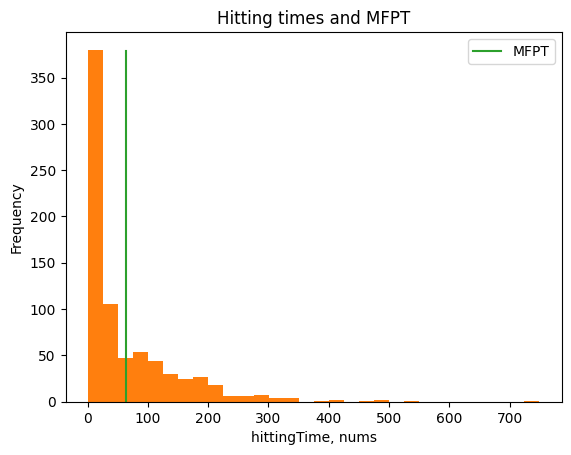

In [6]:
#Histogram hitting times and plot MFPT
hit = hittingTime[hittingTime != 0]
#Should zero be removed for MFPT calculation?
MFPT = np.average(hit)
print("Mean First Passage Time = ", MFPT)
plt.plot(np.tile(MFPT, int(max(plt.hist(hit, 30)[0]))), range(int(max(plt.hist(hit, 30)[0]))), label="MFPT")
#plt.hist(hit, 30, label="Zero removed")
#plt.hist(hittingTime, 30, label="Zero inflated")
plt.ylabel("Frequency")
plt.xlabel("hittingTime, nums")
plt.title("Hitting times and MFPT")
plt.legend()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithPores/Hist_Ito_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

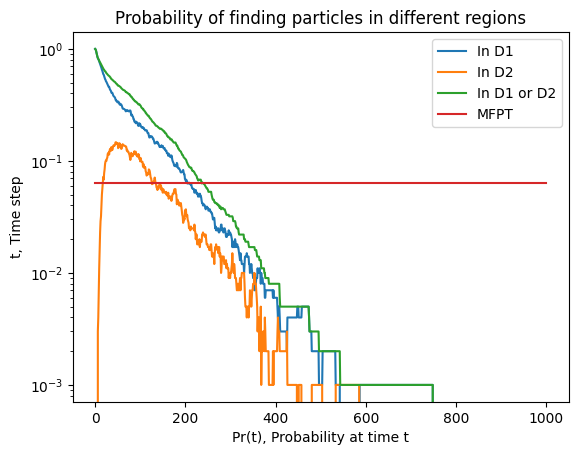

In [7]:
#Probability of finding a particle in medium1 or medium2 or hiting the target
count1 = np.zeros(nums)
count2 = np.zeros(nums)
count3 = np.zeros(nums)
for t in range(nums):
  for p in range(nump):
    count3[t] += np.count_nonzero((0 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R))
    count1[t] += np.count_nonzero((R < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R1))
    count2[t] += np.count_nonzero((R1 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R2))
xticks = np.linspace(1/nums, 1, nums)
yticks = np.linspace(1/nums, 1, nums)
plt.yscale("log")
plt.plot(count1/nump)
plt.plot(count2/nump)
plt.plot((count1 + count2)/nump)
plt.plot(np.tile(MFPT/nums, nums))
#plt.plot(count3/nump)
plt.legend(["In D1", "In D2", "In D1 or D2", "MFPT", "Hit target"])
plt.ylabel("t, Time step")
plt.xlabel("Pr(t), Probability at time t")
plt.title("Probability of finding particles in different regions")
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithPores/Prob_Ito_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

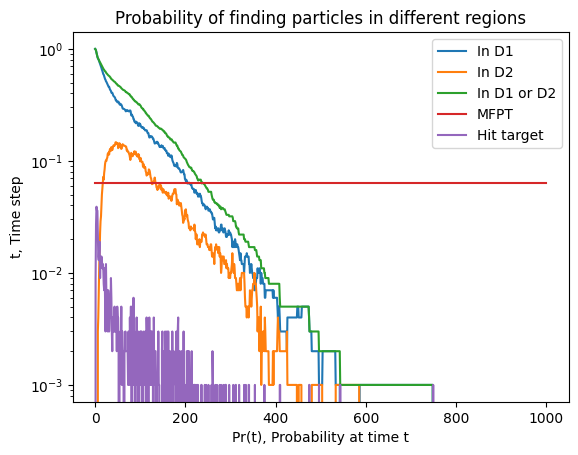

In [8]:
xticks = np.linspace(1/nums, 1, nums)
yticks = np.linspace(1/nums, 1, nums)
plt.yscale("log")
plt.plot(count1/nump)
plt.plot(count2/nump)
plt.plot((count1 + count2)/nump)
plt.plot(np.tile(MFPT/nums, nums))
plt.plot(count3/nump)
plt.legend(["In D1", "In D2", "In D1 or D2", "MFPT", "Hit target"])
plt.ylabel("t, Time step")
plt.xlabel("Pr(t), Probability at time t")
plt.title("Probability of finding particles in different regions")
plt.show()

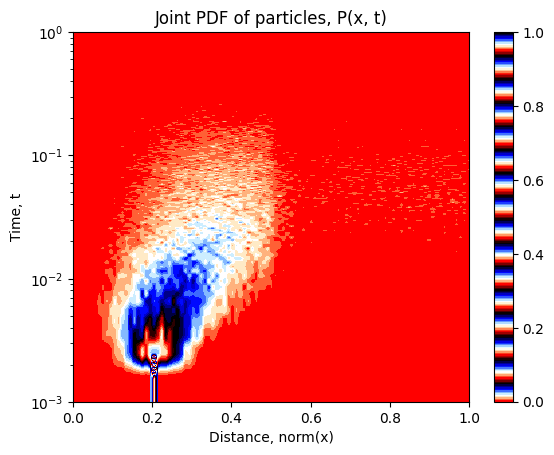

In [9]:
"""Here ALSO it matters if I set a hitting particle to -1 or stick it there norm of hit particles is 1.41"""

"""
W = np.zeros((nums, nump))
#Quantize norm matrix Y for heatmap upto 2 decimal places

for t in range(nums):
  for p in range(nump):
    W[t][p] = np.linalg.norm(Z[:, t, p])
"""
#print(Z)
#print(Z.shape)
#print(Z[0,:,:])
#print(Z[:, 0, :])
#print(np.linalg.norm(Z[:, 1, :], axis=0))
#print(np.linalg.norm(Z[:, 1, 0]))

#W = np.linalg.norm(Z, axis=0)
#print(W.shape)
#print(W)

gridX = 100
gridT = nums
pos = np.round(np.linspace(0, 1, gridX + 1), 2)
tim = np.linspace(0, gridT, gridT+1)
PDF1D = np.zeros((gridT, gridX+1))

#Derive a heatmap of the particles
#Find the norm of particles at each time step - reduce dimension of Y[dim][time][particle] to Z[norm or distance][time]
"""Scale by R2 if necessary but I suspect it is wrong to do so, plots are not as expected for (R1, R2) = (5, 10) as for (0.5, 1)"""
Z = np.linalg.norm(Y/R2, axis=0)

#Quantize it to 2 ( = log10(gridX)) decimal places as grix X is with such precision
Z = np.round(Z, 2)

for t in range(nums):
#position of all particles at time t
  for p in range(len(pos)):
    PDF1D[t][p] = np.count_nonzero(Z[t, :] == pos[p])

#Plot the heatmap of pdf
plt.title("Joint PDF of particles, P(x, t)")
#PDF1D is a 2D matrix with (0,0)th element on top left. Fip vertically
plt.yscale('log')
plt.imshow(np.flipud(PDF1D/nump), cmap = 'flag', extent = [0, 1, dt, dt*nums], aspect = "auto")
plt.xlabel("Distance, norm(x)")
plt.ylabel("Time, t")
plt.colorbar()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithPores/Heat_Ito_{nump}_{nums}_{D1}_{D2}.png')
#print(Z)

#Simulate Stratonovich Convention

In [10]:
#Hitting times if the target is hit
hittingTime = np.zeros(nump)
#Trajectory of a particle
X = np.zeros([dim, nums])
#Trajectories of all particles
Y = np.zeros([dim, nums, nump])


start_time = time.time()
for i in range(nump):
  #Initialize - The particle starts at a random positio outside the target
  if dim == 1:
    X[:, 0] = Init1D[i]
  elif dim == 2:
    X[:, 0] = Init2D[:, i]
  elif dim == 3:
    X[:, 0] = Init3D[:, i]

  #Find particle trajectories
  for j in range(1, nums):
    #Random increment in the position
    dRand = Eps[i, j, :]
    #Increment if particle is in medium1
    dX1 = dX1s[i, j, :]
    #Increment if particle is in medium2
    dX2 = dX2s[i, j, :]

    #Particle travels in medium1, without hitting the target
    if R < np.linalg.norm(X[:, j - 1]) < R1 and R < np.linalg.norm(X[:, j - 1] + dX1) < R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle is traveling in medium2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and R1 < np.linalg.norm(X[:, j - 1] + dX2) < R2:
      X[:, j] = X[:, j - 1] + dX2

    #Particle is reflected by the outer ball when its next step crosses the bound R2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) > R2:
      #Find the point of reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) + np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R2**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Image in D2
      X[:, j] = X[:, j - 1] + dX2 - 2*(1 - lamb)*np.dot(dX2, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

    #Displacement crosses the boundary D1 to D2
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) > R1:
      #Find the point of reflection/diffusion
      lamb = ( -np.dot(X[:, j - 1], dX1) + np.sqrt(np.dot(X[:, j - 1], dX1)**2 - (np.linalg.norm(dX1)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX1)**2)
      r0 = X[:, j - 1] + lamb*dX1
      if any(np.linalg.norm(r0 - poreCenters, axis=1) < r):
        #If particle's projection on surface of the inner ball is near any pore, diffuse to D2.
        #Residence times in each medium
        dt1 = (np.linalg.norm(lamb*dX1)/(np.linalg.norm(dRand)*np.sqrt(2*D1)))**2
        dt2 = ((1 - np.sqrt(dt1/dt))**2)*dt
        #Particle diffuses, increment by motion in D2
        X[:, j] = r0 + np.sqrt(2*D2*dt2)*dRand
        #print(j, "Diffusion from D1 to D2", dt1, dt2, dt, X[:, j], np.linalg.norm(X[:, j]), np.linalg.norm(X[:, j] - X[:, j-1]))
        #print(X[:, j-1])
        #print(X[:, j])
      else:
        #Particle is reflected by inner ball when it's near the media boundary and far from all the pores
        #Image in D1
        X[:, j] = X[:, j - 1] + dX1 - 2*(1-lamb)*np.dot(dX1, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)
        #print(j, "Reflection in D1", X[:, j], np.linalg.norm(X[:, j]), np.linalg.norm(X[:, j] - X[:, j-1]))

    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) < R1:
      #Find the point of reflection/diffusion
      lamb = ( -np.dot(X[:, j - 1], dX2) - np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #If particle projected on surface of ball 1 is near a pore, diffuse to D1. Else reflect it
      if any(np.linalg.norm(r0 - poreCenters, axis=1) < r):
        #Residence times in each medium
        dt2 = (np.linalg.norm(lamb*dX2)/(np.linalg.norm(dRand)*np.sqrt(2*D2)))**2
        dt1 = ((1 - np.sqrt(dt2/dt))**2)*dt
        #Particle diffuses, increment by motion in D1
        X[:, j] = r0 + np.sqrt(2*D1*dt1)*dRand
        #print(j, "Diffusion from D2 to D1", dt1, dt2, dt, X[:, j], np.linalg.norm(X[:, j]), np.linalg.norm(X[:, j] - X[:, j-1]))
      else:
        #Image in D2
        X[:, j] = X[:, j - 1] + dX2 - 2*(1-lamb)*np.dot(dX2, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)
        #print(j, "Reflection in D2", X[:, j], np.linalg.norm(X[:, j]), np.linalg.norm(X[:, j] - X[:, j-1]))

    #Particle hits the target
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) < R:
      X[:, j] = X[:, j - 1] + dX1
      X[:, j+1:] = -1
      hittingTime[i] = j
      break

  #Save the particle's trajectory
  Y[:, :, i] = X
  #print(i)

#Time taken to simulate motion of nump particles each taking nums steps
print("nump = ", nump, "nums = ", nums, "--- %s seconds ---" % (time.time() - start_time))

nump =  1000 nums =  1000 --- 28.00600528717041 seconds ---


# Plots

Mean First Passage Time =  45.62250712250712


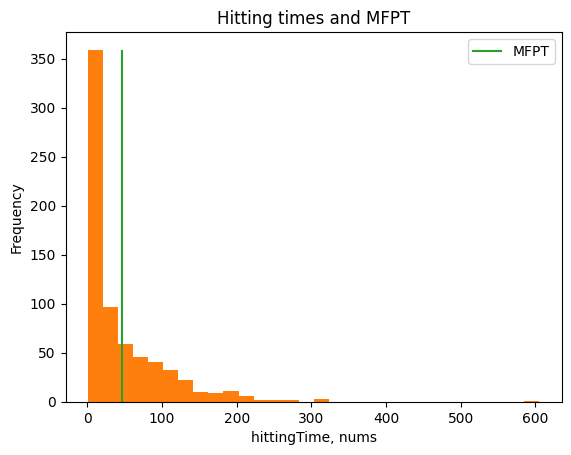

In [11]:
#Histogram hitting times and plot MFPT
hit = hittingTime[hittingTime != 0]
#Should zero be removed for MFPT calculation?
MFPT = np.average(hit)
print("Mean First Passage Time = ", MFPT)
plt.plot(np.tile(MFPT, int(max(plt.hist(hit, 30)[0]))), range(int(max(plt.hist(hit, 30)[0]))), label="MFPT")
#plt.hist(hit, 30, label="Zero removed")
#plt.hist(hittingTime, 30, label="Zero inflated")
plt.ylabel("Frequency")
plt.xlabel("hittingTime, nums")
plt.title("Hitting times and MFPT")
plt.legend()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Hist_Strat_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

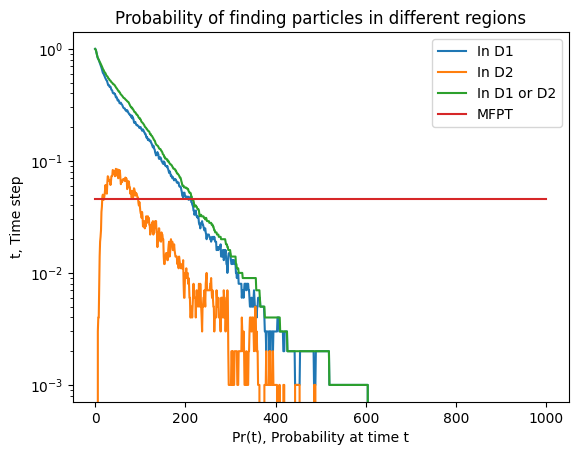

In [12]:
#Probability of finding a particle in medium1 or medium2 or hiting the target
count1 = np.zeros(nums)
count2 = np.zeros(nums)
count3 = np.zeros(nums)
for t in range(nums):
  for p in range(nump):
    """Here it matters if I set a hitting particle to -1 or stick it there"""
    count3[t] += np.count_nonzero((0 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R))
    count1[t] += np.count_nonzero((R < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R1))
    count2[t] += np.count_nonzero((R1 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R2))

xticks = np.linspace(1/nums, 1, nums)
yticks = np.linspace(1/nums, 1, nums)
plt.yscale("log")
plt.plot(count1/nump)
plt.plot(count2/nump)
plt.plot((count1 + count2)/nump)
plt.plot(np.tile(MFPT/nums, nums))
#plt.plot(count3/nump)
plt.legend(["In D1", "In D2", "In D1 or D2", "MFPT", "Hit target"])
plt.ylabel("t, Time step")
plt.xlabel("Pr(t), Probability at time t")
plt.title("Probability of finding particles in different regions")
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Prob_Strat_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

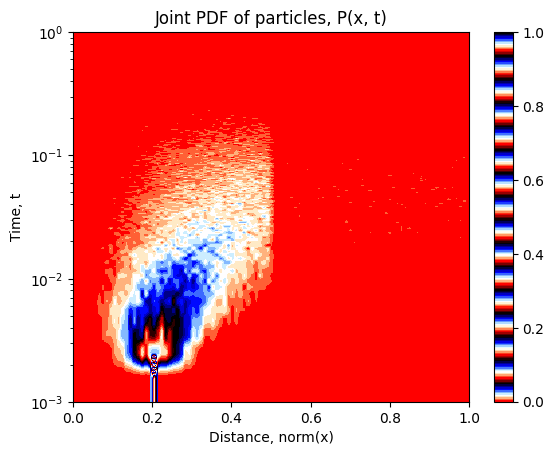

In [13]:
#Plot a heatmap of probability of particles
gridX = 100
gridT = nums
pos = np.round(np.linspace(0, 1, gridX + 1), 2)
tim = np.linspace(0, gridT, gridT+1)
PDF1D = np.zeros((gridT, gridX+1))

#Derive a heatmap of the particles
#Find the norm of particles at each time step
Z = np.linalg.norm(Y/R2, axis=0)

#Quantize it to 2 ( = log10(gridX)) decimal places as grix X is with such precision
Z = np.round(Z, 2)

for t in range(nums):
#position of all particles at time t
  for p in range(len(pos)):
    PDF1D[t][p] = np.count_nonzero(Z[t, :] == pos[p])

#Plot the heatmap of pdf
plt.title("Joint PDF of particles, P(x, t)")
#PDF1D is a 2D matrix with (0,0)th element on top left. Fip vertically
plt.yscale('log')
plt.imshow(np.flipud(PDF1D/nump), cmap = 'flag', extent = [0, 1, dt, dt*nums], aspect = "auto")
plt.xlabel("Distance, norm(x)")
plt.ylabel("Time, t")
plt.colorbar()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Heat_Strat_{nump}_{nums}_{D1}_{D2}.png')

# Simulate Isothermal Convention

In [14]:
#Hitting times if the target is hit
hittingTime = np.zeros(nump)
#Trajectory of a particle
X = np.zeros([dim, nums])
#Trajectories of all particles
Y = np.zeros([dim, nums, nump])


start_time = time.time()
for i in range(nump):
  #Initialize - The particle starts at a random positio outside the target
  if dim == 1:
    X[:, 0] = Init1D[i]
  elif dim == 2:
    X[:, 0] = Init2D[:, i]
  elif dim == 3:
    X[:, 0] = Init3D[:, i]

  #Find particle trajectories
  for j in range(1, nums):
    #Random increment in the position
    dRand = Eps[i, j, :]
    #Increment if particle is in medium1
    dX1 = dX1s[i, j, :]
    #Increment if particle is in medium2
    dX2 = dX2s[i, j, :]

    #Particle hits the target
    if R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) < R:
      X[:, j] = X[:, j - 1] + dX1
      X[:, j+1:] = -1
      hittingTime[i] = j
      break

    #Particle travels in medium1, without hitting the target
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and R < np.linalg.norm(X[:, j - 1] + dX1) < R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle is traveling in medium2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and R1 < np.linalg.norm(X[:, j - 1] + dX2) < R2:
      X[:, j] = X[:, j - 1] + dX2

    #Particle is reflected by the outer ball when its next step crosses the bound R2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) > R2:
      #Find the point of reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) + np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R2**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Image in D2
      X[:, j] = X[:, j - 1] + dX2 - 2*(1 - lamb)*np.dot(dX2, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

    #Particle diffuses from D1 to D2 with a one sided reflection coefficient
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) > R1:
      #Find the point of diffusion/reflection
      lamb = ( -np.dot(X[:, j - 1], dX1) + np.sqrt(np.dot(X[:, j - 1], dX1)**2 - (np.linalg.norm(dX1)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX1)**2)
      r0 = X[:, j - 1] + lamb*dX1
      if any(np.linalg.norm(r0 - poreCenters, axis=1) < r):
        #If particle's projection on surface of the inner ball is near any pore, diffuse to D2.
        if bernoulli.rvs(min(1, math.sqrt(D2/D1))):
          #Diffuse with time-splitting, if the random variable generated is 1
          #Residence times in each medium
          dt1 = (np.linalg.norm(lamb*dX1)/(np.linalg.norm(dRand)*np.sqrt(2*D1)))**2
          dt2 = ((1 - np.sqrt(dt1/dt))**2)*dt
          #Particle diffuses, increment by motion in D2
          X[:, j] = r0 + np.sqrt(2*D2*dt2)*dRand
        else:
          #Reflect, if the random variable generated is 0
          X[:, j] = X[:, j - 1] + dX1 - 2*(1-lamb)*np.dot(dX1, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)
      else:
          #Reflect particle is far from all pores
          X[:, j] = X[:, j - 1] + dX1 - 2*(1-lamb)*np.dot(dX1, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)

    #Particle diffuses from D2 to D1 with a one sided reflection coefficient
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) < R1:
      #Find the point of diffusion/reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) - np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      if any(np.linalg.norm(r0 - poreCenters, axis=1) < r):
        #If particle's projection on surface of the inner ball is near any pore, diffuse to D2.
        if bernoulli.rvs(min(1, math.sqrt(D1/D2))):
          #Diffuse with time-splitting, if the random variable generated is 1
          #Residence times in each medium
          dt2 = (np.linalg.norm(lamb*dX2)/(np.linalg.norm(dRand)*np.sqrt(2*D2)))**2
          dt1 = ((1 - np.sqrt(dt2/dt))**2)*dt
          #Particle diffuses, increment by motion in D1
          X[:, j] = r0 + np.sqrt(2*D1*dt1)*dRand
        else:
          #Reflect, if the random variable generated is 0
          X[:, j] = X[:, j - 1] + dX2 - 2*(1-lamb)*np.dot(dX2, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)
      else:
          #Reflect, if projection is far from all pores
          X[:, j] = X[:, j - 1] + dX2 - 2*(1-lamb)*np.dot(dX2, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)

  #Save the particle's trajectory
  Y[:, :, i] = X
  #print(i)

#Time taken to simulate motion of nump particles each taking nums steps
print("nump = ", nump, "nums = ", nums, "--- %s seconds ---" % (time.time() - start_time))

nump =  1000 nums =  1000 --- 31.736801624298096 seconds ---


# Plots

Mean First Passage Time =  40.214071856287426


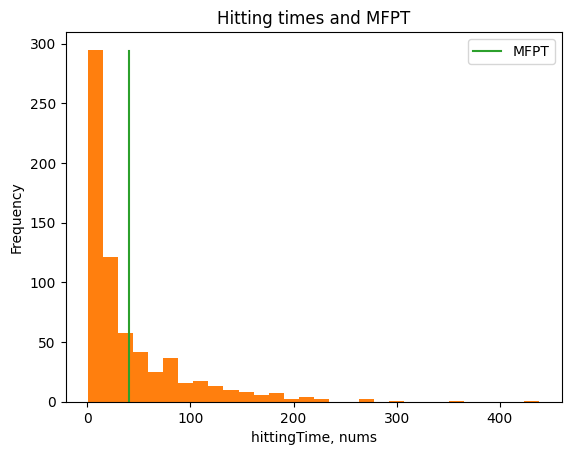

In [15]:
#Histogram hitting times and plot MFPT
hit = hittingTime[hittingTime != 0]
#Should zero be removed for MFPT calculation?
MFPT = np.average(hit)
print("Mean First Passage Time = ", MFPT)
plt.plot(np.tile(MFPT, int(max(plt.hist(hit, 30)[0]))), range(int(max(plt.hist(hit, 30)[0]))), label="MFPT")
#plt.hist(hit, 30, label="Zero removed")
#plt.hist(hittingTime, 30, label="Zero inflated")
plt.ylabel("Frequency")
plt.xlabel("hittingTime, nums")
plt.title("Hitting times and MFPT")
plt.legend()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Hist_Iso_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

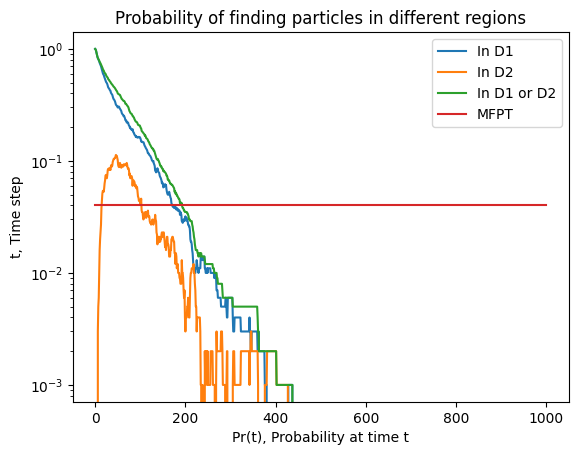

In [16]:
#Probability of finding a particle in medium1 or medium2 or hiting the target
count1 = np.zeros(nums)
count2 = np.zeros(nums)
count3 = np.zeros(nums)
for t in range(nums):
  for p in range(nump):
    count3[t] += np.count_nonzero((0 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R))
    count1[t] += np.count_nonzero((R < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R1))
    count2[t] += np.count_nonzero((R1 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R2))

xticks = np.linspace(1/nums, 1, nums)
yticks = np.linspace(1/nums, 1, nums)
plt.yscale("log")
plt.plot(count1/nump)
plt.plot(count2/nump)
plt.plot((count1 + count2)/nump)
plt.plot(np.tile(MFPT/nums, nums))
#plt.plot(count3/nump)
plt.legend(["In D1", "In D2", "In D1 or D2", "MFPT", "Hit target"])
plt.ylabel("t, Time step")
plt.xlabel("Pr(t), Probability at time t")
plt.title("Probability of finding particles in different regions")
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Prob_Iso_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

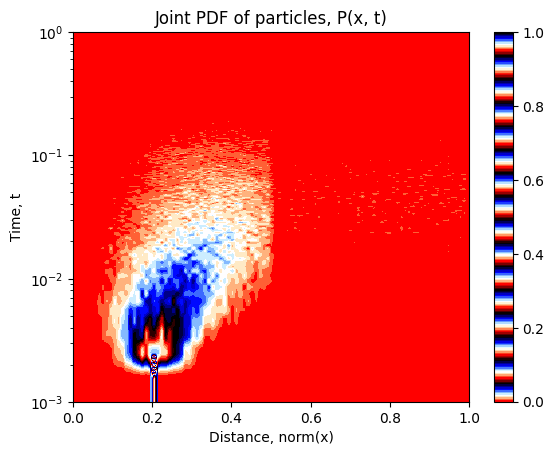

In [17]:
#Plot a heatmap of probability of particles
gridX = 100
gridT = nums
pos = np.round(np.linspace(0, 1, gridX + 1), 2)
tim = np.linspace(0, gridT, gridT+1)
PDF1D = np.zeros((gridT, gridX+1))

#Derive a heatmap of the particles
#Find the norm of particles at each time step
Z = np.linalg.norm(Y/R2, axis=0)

#Quantize it to 2 ( = log10(gridX)) decimal places as grix X is with such precision
Z = np.round(Z, 2)

for t in range(nums):
#position of all particles at time t
  for p in range(len(pos)):
    PDF1D[t][p] = np.count_nonzero(Z[t, :] == pos[p])

#Plot the heatmap of pdf
plt.title("Joint PDF of particles, P(x, t)")
#PDF1D is a 2D matrix with (0,0)th element on top left. Fip vertically
plt.yscale('log')
plt.imshow(np.flipud(PDF1D/nump), cmap = 'flag', extent = [0, 1, dt, dt*nums], aspect = "auto")
plt.xlabel("Distance, norm(x)")
plt.ylabel("Time, t")
plt.colorbar()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Heat_Iso_{nump}_{nums}_{D1}_{D2}.png')

# D1 = 1, D2 = 10

#Simulate Ito Convention

In [18]:
#Diffusivity of inner medium
D1 = 1
#Diffusivity of outer medium
D2 = 10

#Hitting times if the target is hit
hittingTime = np.zeros(nump)
#Trajectory of a particle
X = np.zeros([dim, nums])
#Trajectories of all particles
Y = np.zeros([dim, nums, nump])

In [19]:
start_time = time.time()
for i in range(nump):
  #Initialize - The particle starts at a random position outside the target
  if dim == 1:
    X[:, 0] = Init1D[i]
  if dim == 2:
    X[:, 0] = Init2D[:, i]
  elif dim == 3:
    X[:, 0] = Init3D[:, i]

  #Find particle trajectories
  for j in range(1, nums):
    #Random increment in the position
    dRand = Eps[i, j, :]
    #Increment if particle is in medium1
    dX1 = dX1s[i, j, :]
    #Increment if particle is in medium2
    dX2 = dX2s[i, j, :]

    #Particle hits the target
    if R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) < R:
      X[:, j] = X[:, j - 1] + dX1
      #For plotting
      hittingTime[i] = j
      """TODO - How to remove the particle once it hits the target?"""
      X[:, j+1:] = -1
      #print(j, "Hit", X[:, j], np.linalg.norm(X[:, j]), np.linalg.norm(X[:, j] - X[:, j-1]))
      break

    #Particle is traveling in medium1 outside the target
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and R < np.linalg.norm(X[:, j - 1] + dX1) < R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle is traveling in medium2, without hitting the reflecting boundary
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and R1 < np.linalg.norm(X[:, j - 1] + dX2) < R2:
      X[:, j] = X[:, j - 1] + dX2

    #Particle is reflected by the outer ball when its next step crosses the bound R2 - Reflect in D2
    #https://math.stackexchange.com/questions/13261/how-to-get-a-reflection-vector
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) > R2:
      #Find the point of reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) + np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R2**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Image in D2
      X[:, j] = X[:, j - 1] + dX2 - 2*(1-lamb)*np.dot(dX2, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)

    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) > R1:
      #Find the point of reflection/diffusion
      lamb = ( -np.dot(X[:, j - 1], dX1) + np.sqrt(np.dot(X[:, j - 1], dX1)**2 - (np.linalg.norm(dX1)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX1)**2)
      r0 = X[:, j - 1] + lamb*dX1
      if any(np.linalg.norm(r0 - poreCenters, axis=1) < r):
        #If particle's projection on surface of the inner ball is near any pore, diffuse to D2.
        X[:, j] = X[:, j - 1] + dX1
      else:
        #Particle is reflected by inner ball when it's near the media boundary and far from all the pores
        #Image in D1
        X[:, j] = X[:, j - 1] + dX1 - 2*(1-lamb)*np.dot(dX1, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)
        #print(j, "Reflection in D1", X[:, j], np.linalg.norm(X[:, j]), np.linalg.norm(X[:, j] - X[:, j-1]))

    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) < R1:
      #Find the point of reflection/diffusion
      lamb = ( -np.dot(X[:, j - 1], dX2) - np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #If particle projected on surface of ball 1 is near a pore, diffuse to D1. Else reflect it
      if any(np.linalg.norm(r0 - poreCenters, axis=1) < r):
        #Diffuse to D1 via a pore
        X[:, j] = X[:, j - 1] + dX1
      else:
        #Reflect - Image in D2
        X[:, j] = X[:, j - 1] + dX2 - 2*(1-lamb)*np.dot(dX2, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)
        #print(j, "Reflection in D2", X[:, j], np.linalg.norm(X[:, j]), np.linalg.norm(X[:, j] - X[:, j-1]))
  #Save the particle's trajectory
  Y[:, :, i] = X
  #print(i)

#Time taken to simulate motion of nump particles each taking nums steps
print("nump = ", nump, "nums = ", nums, "--- %s seconds ---" % (time.time() - start_time))

nump =  1000 nums =  1000 --- 17.229661464691162 seconds ---


# Plots

Mean First Passage Time =  63.605228758169936


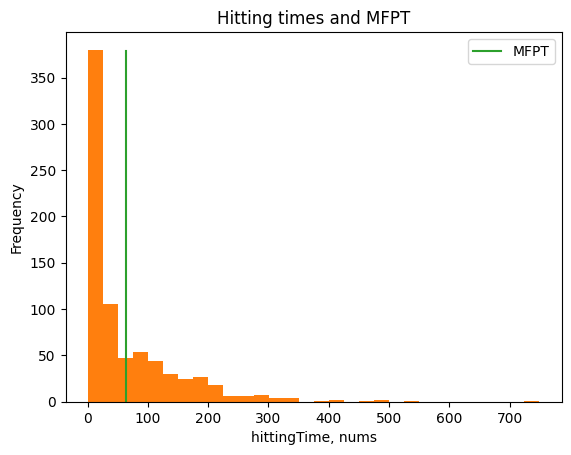

In [20]:
#Histogram hitting times and plot MFPT
hit = hittingTime[hittingTime != 0]
#Should zero be removed for MFPT calculation?
MFPT = np.average(hit)
print("Mean First Passage Time = ", MFPT)
plt.plot(np.tile(MFPT, int(max(plt.hist(hit, 30)[0]))), range(int(max(plt.hist(hit, 30)[0]))), label="MFPT")
#plt.hist(hit, 30, label="Zero removed")
#plt.hist(hittingTime, 30, label="Zero inflated")
plt.ylabel("Frequency")
plt.xlabel("hittingTime, nums")
plt.title("Hitting times and MFPT")
plt.legend()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Hist_Ito_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

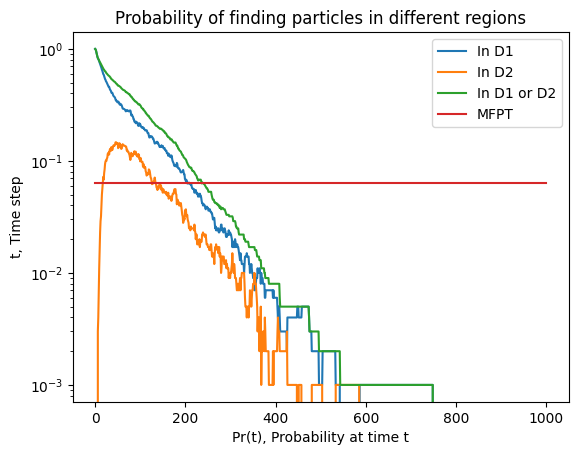

In [21]:
#Probability of finding a particle in medium1 or medium2 or hiting the target
count1 = np.zeros(nums)
count2 = np.zeros(nums)
count3 = np.zeros(nums)
for t in range(nums):
  for p in range(nump):
    count3[t] += np.count_nonzero((0 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R))
    count1[t] += np.count_nonzero((R < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R1))
    count2[t] += np.count_nonzero((R1 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R2))

xticks = np.linspace(1/nums, 1, nums)
yticks = np.linspace(1/nums, 1, nums)
plt.yscale("log")
plt.plot(count1/nump)
plt.plot(count2/nump)
plt.plot((count1 + count2)/nump)
plt.plot(np.tile(MFPT/nums, nums))
#plt.plot(count3/nump)
plt.legend(["In D1", "In D2", "In D1 or D2", "MFPT", "Hit target"])
plt.ylabel("t, Time step")
plt.xlabel("Pr(t), Probability at time t")
plt.title("Probability of finding particles in different regions")
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Prob_Ito_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

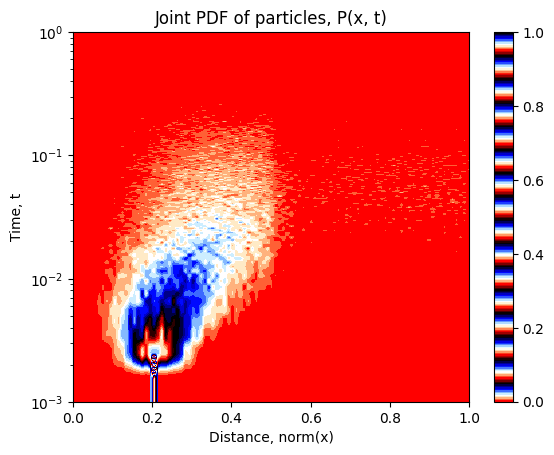

In [22]:
#Plot a heatmap of probability of particles
gridX = 100
gridT = nums
pos = np.round(np.linspace(0, 1, gridX + 1), 2)
tim = np.linspace(0, gridT, gridT+1)
PDF1D = np.zeros((gridT, gridX+1))

#Derive a heatmap of the particles
#Find the norm of particles at each time step
Z = np.linalg.norm(Y/R2, axis=0)

#Quantize it to 2 ( = log10(gridX)) decimal places as grix X is with such precision
Z = np.round(Z, 2)

for t in range(nums):
#position of all particles at time t
  for p in range(len(pos)):
    PDF1D[t][p] = np.count_nonzero(Z[t, :] == pos[p])

#Plot the heatmap of pdf
plt.title("Joint PDF of particles, P(x, t)")
#PDF1D is a 2D matrix with (0,0)th element on top left. Fip vertically
plt.yscale('log')
plt.imshow(np.flipud(PDF1D/nump), cmap = 'flag', extent = [0, 1, dt, dt*nums], aspect = "auto")
plt.xlabel("Distance, norm(x)")
plt.ylabel("Time, t")
plt.colorbar()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Heat_Ito_{nump}_{nums}_{D1}_{D2}.png')

#Simulate Stratonovich Convention

In [23]:
#Hitting times if the target is hit
hittingTime = np.zeros(nump)
#Trajectory of a particle
X = np.zeros([dim, nums])
#Trajectories of all particles
Y = np.zeros([dim, nums, nump])


start_time = time.time()
for i in range(nump):
  #Initialize - The particle starts at a random positio outside the target
  if dim == 1:
    X[:, 0] = Init1D[i]
  elif dim == 2:
    X[:, 0] = Init2D[:, i]
  elif dim == 3:
    X[:, 0] = Init3D[:, i]

  #Find particle trajectories
  for j in range(1, nums):
    #Random increment in the position
    dRand = Eps[i, j, :]
    #Increment if particle is in medium1
    dX1 = dX1s[i, j, :]
    #Increment if particle is in medium2
    dX2 = dX2s[i, j, :]

    #Particle travels in medium1, without hitting the target
    if R < np.linalg.norm(X[:, j - 1]) < R1 and R < np.linalg.norm(X[:, j - 1] + dX1) < R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle is traveling in medium2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and R1 < np.linalg.norm(X[:, j - 1] + dX2) < R2:
      X[:, j] = X[:, j - 1] + dX2

    #Particle is reflected by the outer ball when its next step crosses the bound R2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) > R2:
      #Find the point of reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) + np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R2**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Image in D2
      X[:, j] = X[:, j - 1] + dX2 - 2*(1 - lamb)*np.dot(dX2, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) > R1:
      #Find the point of reflection/diffusion
      lamb = ( -np.dot(X[:, j - 1], dX1) + np.sqrt(np.dot(X[:, j - 1], dX1)**2 - (np.linalg.norm(dX1)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX1)**2)
      r0 = X[:, j - 1] + lamb*dX1
      if any(np.linalg.norm(r0 - poreCenters, axis=1) < r):
        #If particle's projection on surface of the inner ball is near any pore, diffuse to D2.
        #Residence times in each medium
        dt1 = (np.linalg.norm(lamb*dX1)/(np.linalg.norm(dRand)*np.sqrt(2*D1)))**2
        dt2 = ((1 - np.sqrt(dt1/dt))**2)*dt
        #Particle diffuses, increment by motion in D2
        X[:, j] = r0 + np.sqrt(2*D2*dt2)*dRand
        #print(j, "Diffusion from D1 to D2", dt1, dt2, dt, X[:, j], np.linalg.norm(X[:, j]), np.linalg.norm(X[:, j] - X[:, j-1]))
        #print(X[:, j-1])
        #print(X[:, j])
      else:
        #Particle is reflected by inner ball when it's near the media boundary and far from all the pores
        #Image in D1
        X[:, j] = X[:, j - 1] + dX1 - 2*(1-lamb)*np.dot(dX1, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)
        #print(j, "Reflection in D1", X[:, j], np.linalg.norm(X[:, j]), np.linalg.norm(X[:, j] - X[:, j-1]))

    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) < R1:
      #Find the point of reflection/diffusion
      lamb = ( -np.dot(X[:, j - 1], dX2) - np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #If particle projected on surface of ball 1 is near a pore, diffuse to D1. Else reflect it
      if any(np.linalg.norm(r0 - poreCenters, axis=1) < r):
        #Residence times in each medium
        dt2 = (np.linalg.norm(lamb*dX2)/(np.linalg.norm(dRand)*np.sqrt(2*D2)))**2
        dt1 = ((1 - np.sqrt(dt2/dt))**2)*dt
        #Particle diffuses, increment by motion in D1
        X[:, j] = r0 + np.sqrt(2*D1*dt1)*dRand
        #print(j, "Diffusion from D2 to D1", dt1, dt2, dt, X[:, j], np.linalg.norm(X[:, j]), np.linalg.norm(X[:, j] - X[:, j-1]))
      else:
        #Image in D2
        X[:, j] = X[:, j - 1] + dX2 - 2*(1-lamb)*np.dot(dX2, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)
        #print(j, "Reflection in D2", X[:, j], np.linalg.norm(X[:, j]), np.linalg.norm(X[:, j] - X[:, j-1]))

    #Particle hits the target
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) < R:
      X[:, j] = X[:, j - 1] + dX1
      X[:, j+1:] = -1
      hittingTime[i] = j
      break

  #Save the particle's trajectory
  Y[:, :, i] = X
  #print(i)

#Time taken to simulate motion of nump particles each taking nums steps
print("nump = ", nump, "nums = ", nums, "--- %s seconds ---" % (time.time() - start_time))

nump =  1000 nums =  1000 --- 8.74631667137146 seconds ---


# Plots

Mean First Passage Time =  74.7639225181598


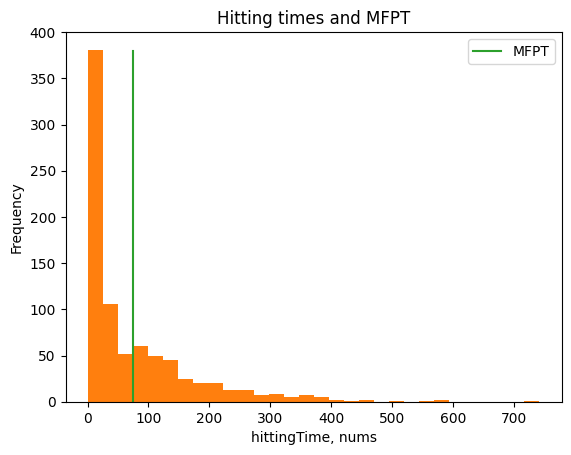

In [24]:
#Histogram hitting times and plot MFPT
hit = hittingTime[hittingTime != 0]
#Should zero be removed for MFPT calculation?
MFPT = np.average(hit)
print("Mean First Passage Time = ", MFPT)
plt.plot(np.tile(MFPT, int(max(plt.hist(hit, 30)[0]))), range(int(max(plt.hist(hit, 30)[0]))), label="MFPT")
#plt.hist(hit, 30, label="Zero removed")
#plt.hist(hittingTime, 30, label="Zero inflated")
plt.ylabel("Frequency")
plt.xlabel("hittingTime, nums")
plt.title("Hitting times and MFPT")
plt.legend()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Hist_Strat_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

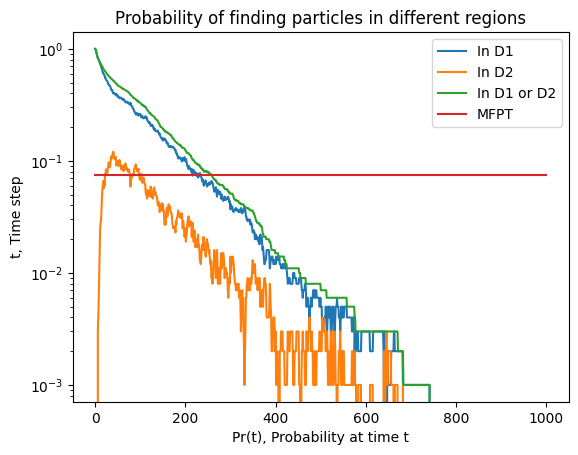

In [25]:
#Probability of finding a particle in medium1 or medium2 or hiting the target
count1 = np.zeros(nums)
count2 = np.zeros(nums)
count3 = np.zeros(nums)
for t in range(nums):
  for p in range(nump):
    count3[t] += np.count_nonzero((0 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R))
    count1[t] += np.count_nonzero((R < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R1))
    count2[t] += np.count_nonzero((R1 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R2))

xticks = np.linspace(1/nums, 1, nums)
yticks = np.linspace(1/nums, 1, nums)
plt.yscale("log")
plt.plot(count1/nump)
plt.plot(count2/nump)
plt.plot((count1 + count2)/nump)
plt.plot(np.tile(MFPT/nums, nums))
#plt.plot(count3/nump)
plt.legend(["In D1", "In D2", "In D1 or D2", "MFPT", "Hit target"])
plt.ylabel("t, Time step")
plt.xlabel("Pr(t), Probability at time t")
plt.title("Probability of finding particles in different regions")
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Prob_Strat_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

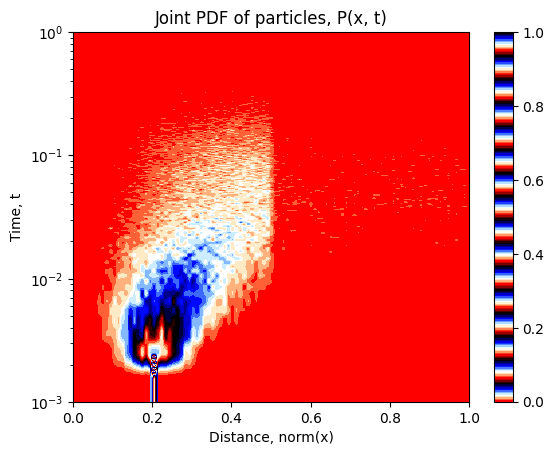

In [26]:
#Plot a heatmap of probability of particles
gridX = 100
gridT = nums
pos = np.round(np.linspace(0, 1, gridX + 1), 2)
tim = np.linspace(0, gridT, gridT+1)
PDF1D = np.zeros((gridT, gridX+1))

#Derive a heatmap of the particles
#Find the norm of particles at each time step
Z = np.linalg.norm(Y/R2, axis=0)

#Quantize it to 2 ( = log10(gridX)) decimal places as grix X is with such precision
Z = np.round(Z, 2)

for t in range(nums):
#position of all particles at time t
  for p in range(len(pos)):
    PDF1D[t][p] = np.count_nonzero(Z[t, :] == pos[p])

#Plot the heatmap of pdf
plt.title("Joint PDF of particles, P(x, t)")
#PDF1D is a 2D matrix with (0,0)th element on top left. Fip vertically
plt.yscale('log')
plt.imshow(np.flipud(PDF1D/nump), cmap = 'flag', extent = [0, 1, dt, dt*nums], aspect = "auto")
plt.xlabel("Distance, norm(x)")
plt.ylabel("Time, t")
plt.colorbar()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Heat_Strat_{nump}_{nums}_{D1}_{D2}.png')
#https://stackoverflow.com/questions/2546475/how-can-i-draw-a-log-normalized-imshow-plot-with-a-colorbar-representing-the-raw

# Simulate Isothermal Convention

In [27]:
#Hitting times if the target is hit
hittingTime = np.zeros(nump)
#Trajectory of a particle
X = np.zeros([dim, nums])
#Trajectories of all particles
Y = np.zeros([dim, nums, nump])


start_time = time.time()
for i in range(nump):
  #Initialize - The particle starts at a random positio outside the target
  if dim == 1:
    X[:, 0] = Init1D[i]
  elif dim == 2:
    X[:, 0] = Init2D[:, i]
  elif dim == 3:
    X[:, 0] = Init3D[:, i]

  #Find particle trajectories
  for j in range(1, nums):
    #Random increment in the position
    dRand = Eps[i, j, :]
    #Increment if particle is in medium1
    dX1 = dX1s[i, j, :]
    #Increment if particle is in medium2
    dX2 = dX2s[i, j, :]

    #Particle hits the target
    if R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) < R:
      X[:, j] = X[:, j - 1] + dX1
      X[:, j+1:] = -1
      hittingTime[i] = j
      break

    #Particle travels in medium1, without hitting the target
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and R < np.linalg.norm(X[:, j - 1] + dX1) < R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle is traveling in medium2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and R1 < np.linalg.norm(X[:, j - 1] + dX2) < R2:
      X[:, j] = X[:, j - 1] + dX2

    #Particle is reflected by the outer ball when its next step crosses the bound R2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) > R2:
      #Find the point of reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) + np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R2**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Image in D2
      X[:, j] = X[:, j - 1] + dX2 - 2*(1 - lamb)*np.dot(dX2, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

    #Particle diffuses from D1 to D2 with a one sided reflection coefficient
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) > R1:
      #Find the point of diffusion/reflection
      lamb = ( -np.dot(X[:, j - 1], dX1) + np.sqrt(np.dot(X[:, j - 1], dX1)**2 - (np.linalg.norm(dX1)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX1)**2)
      r0 = X[:, j - 1] + lamb*dX1
      if any(np.linalg.norm(r0 - poreCenters, axis=1) < r):
        #If particle's projection on surface of the inner ball is near any pore, diffuse to D2.
        if bernoulli.rvs(min(1, math.sqrt(D2/D1))):
          #Diffuse with time-splitting, if the random variable generated is 1
          #Residence times in each medium
          dt1 = (np.linalg.norm(lamb*dX1)/(np.linalg.norm(dRand)*np.sqrt(2*D1)))**2
          dt2 = ((1 - np.sqrt(dt1/dt))**2)*dt
          #Particle diffuses, increment by motion in D2
          X[:, j] = r0 + np.sqrt(2*D2*dt2)*dRand
        else:
          #Reflect, if the random variable generated is 0
          X[:, j] = X[:, j - 1] + dX1 - 2*(1-lamb)*np.dot(dX1, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)
      else:
          #Reflect particle is far from all pores
          X[:, j] = X[:, j - 1] + dX1 - 2*(1-lamb)*np.dot(dX1, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)

    #Particle diffuses from D2 to D1 with a one sided reflection coefficient
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) < R1:
      #Find the point of diffusion/reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) - np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      if any(np.linalg.norm(r0 - poreCenters, axis=1) < r):
        #If particle's projection on surface of the inner ball is near any pore, diffuse to D2.
        if bernoulli.rvs(min(1, math.sqrt(D1/D2))):
          #Diffuse with time-splitting, if the random variable generated is 1
          #Residence times in each medium
          dt2 = (np.linalg.norm(lamb*dX2)/(np.linalg.norm(dRand)*np.sqrt(2*D2)))**2
          dt1 = ((1 - np.sqrt(dt2/dt))**2)*dt
          #Particle diffuses, increment by motion in D1
          X[:, j] = r0 + np.sqrt(2*D1*dt1)*dRand
        else:
          #Reflect, if the random variable generated is 0
          X[:, j] = X[:, j - 1] + dX2 - 2*(1-lamb)*np.dot(dX2, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)
      else:
          #Reflect, if projection is far from all pores
          X[:, j] = X[:, j - 1] + dX2 - 2*(1-lamb)*np.dot(dX2, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)

  #Save the particle's trajectory
  Y[:, :, i] = X
  #print(i)

#Time taken to simulate motion of nump particles each taking nums steps
print("nump = ", nump, "nums = ", nums, "--- %s seconds ---" % (time.time() - start_time))

nump =  1000 nums =  1000 --- 15.192432641983032 seconds ---


# Plots

Mean First Passage Time =  51.02949438202247


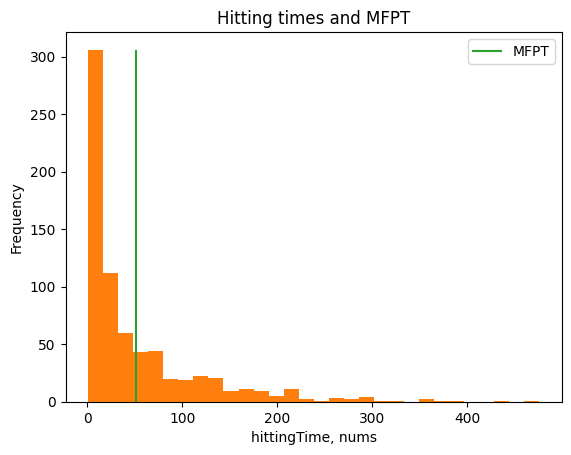

In [28]:
#Histogram hitting times and plot MFPT
hit = hittingTime[hittingTime != 0]
#Should zero be removed for MFPT calculation?
MFPT = np.average(hit)
print("Mean First Passage Time = ", MFPT)
plt.plot(np.tile(MFPT, int(max(plt.hist(hit, 30)[0]))), range(int(max(plt.hist(hit, 30)[0]))), label="MFPT")
#plt.hist(hit, 30, label="Zero removed")
#plt.hist(hittingTime, 30, label="Zero inflated")
plt.ylabel("Frequency")
plt.xlabel("hittingTime, nums")
plt.title("Hitting times and MFPT")
plt.legend()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Hist_Iso_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

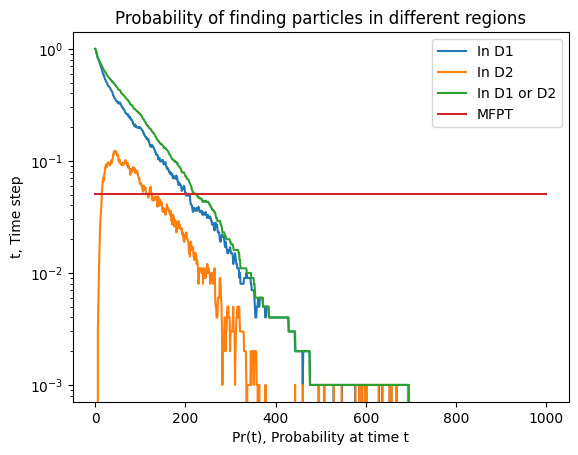

In [29]:
#Probability of finding a particle in medium1 or medium2 or hiting the target
count1 = np.zeros(nums)
count2 = np.zeros(nums)
count3 = np.zeros(nums)
for t in range(nums):
  for p in range(nump):
    count3[t] += np.count_nonzero((0 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R))
    count1[t] += np.count_nonzero((R < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R1))
    count2[t] += np.count_nonzero((R1 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R2))

xticks = np.linspace(1/nums, 1, nums)
yticks = np.linspace(1/nums, 1, nums)
plt.yscale("log")
plt.plot(count1/nump)
plt.plot(count2/nump)
plt.plot((count1 + count2)/nump)
plt.plot(np.tile(MFPT/nums, nums))
#plt.plot(count3/nump)
plt.legend(["In D1", "In D2", "In D1 or D2", "MFPT", "Hit target"])
plt.ylabel("t, Time step")
plt.xlabel("Pr(t), Probability at time t")
plt.title("Probability of finding particles in different regions")
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Prob_Iso_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

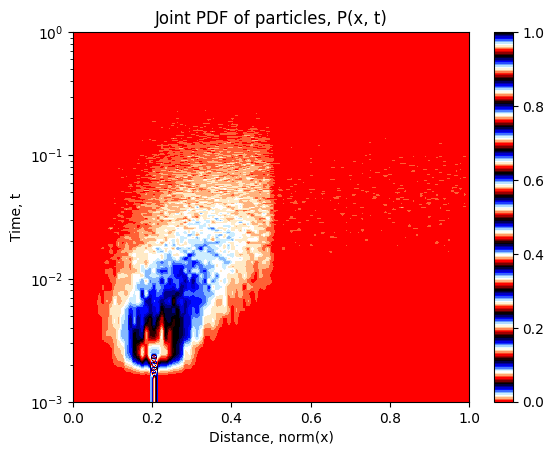

In [30]:
#Plot a heatmap of probability of particles
gridX = 100
gridT = nums
pos = np.round(np.linspace(0, 1, gridX + 1), 2)
tim = np.linspace(0, gridT, gridT+1)
PDF1D = np.zeros((gridT, gridX+1))

#Derive a heatmap of the particles
#Find the norm of particles at each time step
Z = np.linalg.norm(Y/R2, axis=0)

#Quantize it to 2 ( = log10(gridX)) decimal places as grix X is with such precision
Z = np.round(Z, 2)

for t in range(nums):
#position of all particles at time t
  for p in range(len(pos)):
    PDF1D[t][p] = np.count_nonzero(Z[t, :] == pos[p])

#Plot the heatmap of pdf
plt.title("Joint PDF of particles, P(x, t)")
#PDF1D is a 2D matrix with (0,0)th element on top left. Fip vertically
plt.yscale('log')
plt.imshow(np.flipud(PDF1D/nump), cmap = 'flag', extent = [0, 1, dt, dt*nums], aspect = "auto")
plt.xlabel("Distance, norm(x)")
plt.ylabel("Time, t")
plt.colorbar()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Heat_Ito_{nump}_{nums}_{D1}_{D2}.png')

# D1 = 1, D2 = 1.1

#Simulate Ito Convention

In [31]:
#Diffusivity of inner medium
D1 = 1
#Diffusivity of outer medium
D2 = 1.1

#Hitting times if the target is hit
hittingTime = np.zeros(nump)
#Trajectory of a particle
X = np.zeros([dim, nums])
#Trajectories of all particles
Y = np.zeros([dim, nums, nump])

In [32]:
start_time = time.time()
for i in range(nump):
  #Initialize - The particle starts at a random position outside the target
  if dim == 1:
    X[:, 0] = Init1D[i]
  if dim == 2:
    X[:, 0] = Init2D[:, i]
  elif dim == 3:
    X[:, 0] = Init3D[:, i]

  #Find particle trajectories
  for j in range(1, nums):
    #Random increment in the position
    dRand = Eps[i, j, :]
    #Increment if particle is in medium1
    dX1 = dX1s[i, j, :]
    #Increment if particle is in medium2
    dX2 = dX2s[i, j, :]

    #Particle hits the target
    if R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) < R:
      X[:, j] = X[:, j - 1] + dX1
      #For plotting
      hittingTime[i] = j
      """TODO - How to remove the particle once it hits the target?"""
      X[:, j+1:] = -1
      #print(j, "Hit", X[:, j], np.linalg.norm(X[:, j]), np.linalg.norm(X[:, j] - X[:, j-1]))
      break

    #Particle is traveling in medium1 outside the target
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and R < np.linalg.norm(X[:, j - 1] + dX1) < R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle is traveling in medium2, without hitting the reflecting boundary
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and R1 < np.linalg.norm(X[:, j - 1] + dX2) < R2:
      X[:, j] = X[:, j - 1] + dX2

    #Particle is reflected by the outer ball when its next step crosses the bound R2 - Reflect in D2
    #https://math.stackexchange.com/questions/13261/how-to-get-a-reflection-vector
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) > R2:
      #Find the point of reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) + np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R2**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Image in D2
      X[:, j] = X[:, j - 1] + dX2 - 2*(1-lamb)*np.dot(dX2, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)

    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) > R1:
      #Find the point of reflection/diffusion
      lamb = ( -np.dot(X[:, j - 1], dX1) + np.sqrt(np.dot(X[:, j - 1], dX1)**2 - (np.linalg.norm(dX1)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX1)**2)
      r0 = X[:, j - 1] + lamb*dX1
      if any(np.linalg.norm(r0 - poreCenters, axis=1) < r):
        #If particle's projection on surface of the inner ball is near any pore, diffuse to D2.
        X[:, j] = X[:, j - 1] + dX1
      else:
        #Particle is reflected by inner ball when it's near the media boundary and far from all the pores
        #Image in D1
        X[:, j] = X[:, j - 1] + dX1 - 2*(1-lamb)*np.dot(dX1, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)
        #print(j, "Reflection in D1", X[:, j], np.linalg.norm(X[:, j]), np.linalg.norm(X[:, j] - X[:, j-1]))

    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) < R1:
      #Find the point of reflection/diffusion
      lamb = ( -np.dot(X[:, j - 1], dX2) - np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #If particle projected on surface of ball 1 is near a pore, diffuse to D1. Else reflect it
      if any(np.linalg.norm(r0 - poreCenters, axis=1) < r):
        #Diffuse to D1 via a pore
        X[:, j] = X[:, j - 1] + dX1
      else:
        #Reflect - Image in D2
        X[:, j] = X[:, j - 1] + dX2 - 2*(1-lamb)*np.dot(dX2, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)
        #print(j, "Reflection in D2", X[:, j], np.linalg.norm(X[:, j]), np.linalg.norm(X[:, j] - X[:, j-1]))
  #Save the particle's trajectory
  Y[:, :, i] = X
  #print(i)

#Time taken to simulate motion of nump particles each taking nums steps
print("nump = ", nump, "nums = ", nums, "--- %s seconds ---" % (time.time() - start_time))

nump =  1000 nums =  1000 --- 13.533632278442383 seconds ---


# Plots

Mean First Passage Time =  63.605228758169936


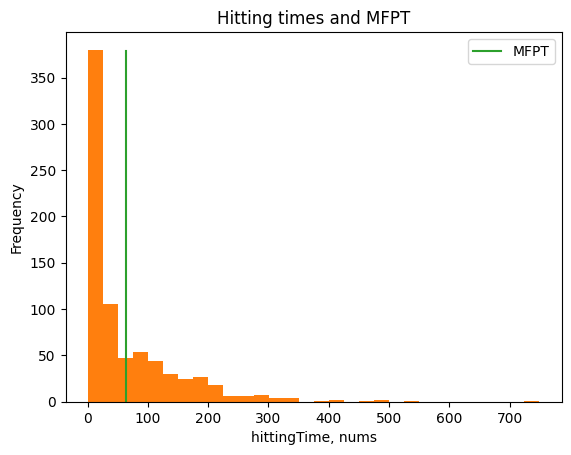

In [33]:
#Histogram hitting times and plot MFPT
hit = hittingTime[hittingTime != 0]
#Should zero be removed for MFPT calculation?
MFPT = np.average(hit)
print("Mean First Passage Time = ", MFPT)
plt.plot(np.tile(MFPT, int(max(plt.hist(hit, 30)[0]))), range(int(max(plt.hist(hit, 30)[0]))), label="MFPT")
#plt.hist(hit, 30, label="Zero removed")
#plt.hist(hittingTime, 30, label="Zero inflated")
plt.ylabel("Frequency")
plt.xlabel("hittingTime, nums")
plt.title("Hitting times and MFPT")
plt.legend()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Hist_Ito_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

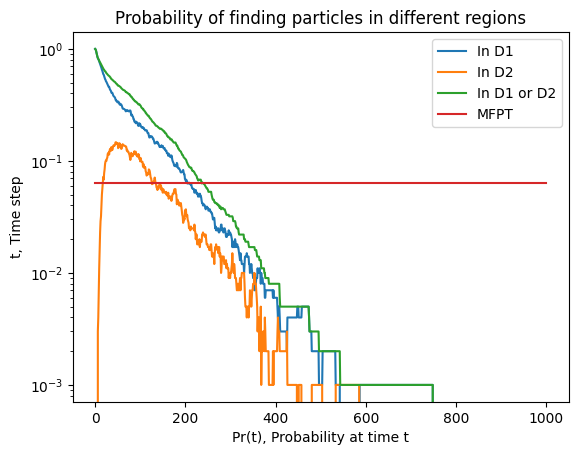

In [34]:
#Probability of finding a particle in medium1 or medium2 or hiting the target
count1 = np.zeros(nums)
count2 = np.zeros(nums)
count3 = np.zeros(nums)
for t in range(nums):
  for p in range(nump):
    count3[t] += np.count_nonzero((0 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R))
    count1[t] += np.count_nonzero((R < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R1))
    count2[t] += np.count_nonzero((R1 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R2))

xticks = np.linspace(1/nums, 1, nums)
yticks = np.linspace(1/nums, 1, nums)
plt.yscale("log")
plt.plot(count1/nump)
plt.plot(count2/nump)
plt.plot((count1 + count2)/nump)
plt.plot(np.tile(MFPT/nums, nums))
#plt.plot(count3/nump)
plt.legend(["In D1", "In D2", "In D1 or D2", "MFPT", "Hit target"])
plt.ylabel("t, Time step")
plt.xlabel("Pr(t), Probability at time t")
plt.title("Probability of finding particles in different regions")
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Prob_Ito_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

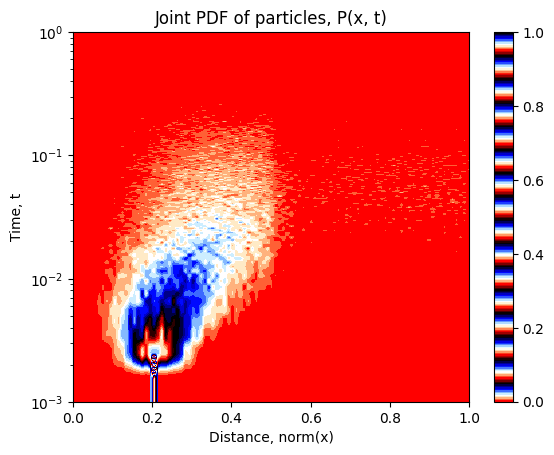

In [35]:
#Plot a heatmap of probability of particles
gridX = 100
gridT = nums
pos = np.round(np.linspace(0, 1, gridX + 1), 2)
tim = np.linspace(0, gridT, gridT+1)
PDF1D = np.zeros((gridT, gridX+1))

#Derive a heatmap of the particles
#Find the norm of particles at each time step
Z = np.linalg.norm(Y/R2, axis=0)

#Quantize it to 2 ( = log10(gridX)) decimal places as grix X is with such precision
Z = np.round(Z, 2)

for t in range(nums):
#position of all particles at time t
  for p in range(len(pos)):
    PDF1D[t][p] = np.count_nonzero(Z[t, :] == pos[p])

#Plot the heatmap of pdf
plt.title("Joint PDF of particles, P(x, t)")
#PDF1D is a 2D matrix with (0,0)th element on top left. Fip vertically
plt.yscale('log')
plt.imshow(np.flipud(PDF1D/nump), cmap = 'flag', extent = [0, 1, dt, dt*nums], aspect = "auto")
plt.xlabel("Distance, norm(x)")
plt.ylabel("Time, t")
plt.colorbar()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Heat_Ito_{nump}_{nums}_{D1}_{D2}.png')

#Simulate Stratonovich Convention

In [36]:
#Hitting times if the target is hit
hittingTime = np.zeros(nump)
#Trajectory of a particle
X = np.zeros([dim, nums])
#Trajectories of all particles
Y = np.zeros([dim, nums, nump])


start_time = time.time()
for i in range(nump):
  #Initialize - The particle starts at a random positio outside the target
  if dim == 1:
    X[:, 0] = Init1D[i]
  elif dim == 2:
    X[:, 0] = Init2D[:, i]
  elif dim == 3:
    X[:, 0] = Init3D[:, i]

  #Find particle trajectories
  for j in range(1, nums):
    #Random increment in the position
    dRand = Eps[i, j, :]
    #Increment if particle is in medium1
    dX1 = dX1s[i, j, :]
    #Increment if particle is in medium2
    dX2 = dX2s[i, j, :]

    #Particle travels in medium1, without hitting the target
    if R < np.linalg.norm(X[:, j - 1]) < R1 and R < np.linalg.norm(X[:, j - 1] + dX1) < R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle is traveling in medium2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and R1 < np.linalg.norm(X[:, j - 1] + dX2) < R2:
      X[:, j] = X[:, j - 1] + dX2

    #Particle is reflected by the outer ball when its next step crosses the bound R2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) > R2:
      #Find the point of reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) + np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R2**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Image in D2
      X[:, j] = X[:, j - 1] + dX2 - 2*(1 - lamb)*np.dot(dX2, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) > R1:
      #Find the point of reflection/diffusion
      lamb = ( -np.dot(X[:, j - 1], dX1) + np.sqrt(np.dot(X[:, j - 1], dX1)**2 - (np.linalg.norm(dX1)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX1)**2)
      r0 = X[:, j - 1] + lamb*dX1
      if any(np.linalg.norm(r0 - poreCenters, axis=1) < r):
        #If particle's projection on surface of the inner ball is near any pore, diffuse to D2.
        #Residence times in each medium
        dt1 = (np.linalg.norm(lamb*dX1)/(np.linalg.norm(dRand)*np.sqrt(2*D1)))**2
        dt2 = ((1 - np.sqrt(dt1/dt))**2)*dt
        #Particle diffuses, increment by motion in D2
        X[:, j] = r0 + np.sqrt(2*D2*dt2)*dRand
        #print(j, "Diffusion from D1 to D2", dt1, dt2, dt, X[:, j], np.linalg.norm(X[:, j]), np.linalg.norm(X[:, j] - X[:, j-1]))
        #print(X[:, j-1])
        #print(X[:, j])
      else:
        #Particle is reflected by inner ball when it's near the media boundary and far from all the pores
        #Image in D1
        X[:, j] = X[:, j - 1] + dX1 - 2*(1-lamb)*np.dot(dX1, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)
        #print(j, "Reflection in D1", X[:, j], np.linalg.norm(X[:, j]), np.linalg.norm(X[:, j] - X[:, j-1]))

    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) < R1:
      #Find the point of reflection/diffusion
      lamb = ( -np.dot(X[:, j - 1], dX2) - np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #If particle projected on surface of ball 1 is near a pore, diffuse to D1. Else reflect it
      if any(np.linalg.norm(r0 - poreCenters, axis=1) < r):
        #Residence times in each medium
        dt2 = (np.linalg.norm(lamb*dX2)/(np.linalg.norm(dRand)*np.sqrt(2*D2)))**2
        dt1 = ((1 - np.sqrt(dt2/dt))**2)*dt
        #Particle diffuses, increment by motion in D1
        X[:, j] = r0 + np.sqrt(2*D1*dt1)*dRand
        #print(j, "Diffusion from D2 to D1", dt1, dt2, dt, X[:, j], np.linalg.norm(X[:, j]), np.linalg.norm(X[:, j] - X[:, j-1]))
      else:
        #Image in D2
        X[:, j] = X[:, j - 1] + dX2 - 2*(1-lamb)*np.dot(dX2, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)
        #print(j, "Reflection in D2", X[:, j], np.linalg.norm(X[:, j]), np.linalg.norm(X[:, j] - X[:, j-1]))

    #Particle hits the target
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) < R:
      X[:, j] = X[:, j - 1] + dX1
      X[:, j+1:] = -1
      hittingTime[i] = j
      break

  #Save the particle's trajectory
  Y[:, :, i] = X
  #print(i)

#Time taken to simulate motion of nump particles each taking nums steps
print("nump = ", nump, "nums = ", nums, "--- %s seconds ---" % (time.time() - start_time))

nump =  1000 nums =  1000 --- 9.222316980361938 seconds ---


# Plots

Mean First Passage Time =  75.49825378346915


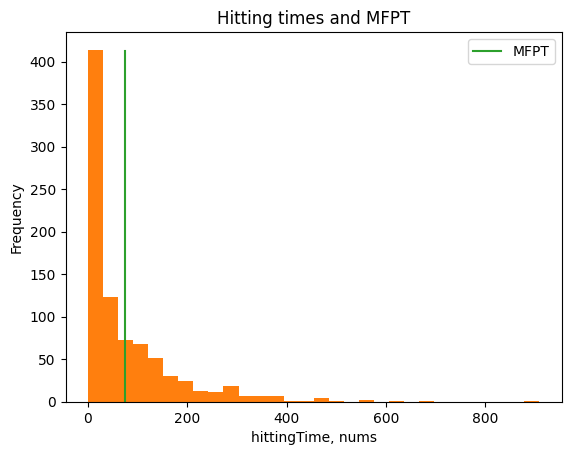

In [37]:
#Histogram hitting times and plot MFPT
hit = hittingTime[hittingTime != 0]
#Should zero be removed for MFPT calculation?
MFPT = np.average(hit)
print("Mean First Passage Time = ", MFPT)
plt.plot(np.tile(MFPT, int(max(plt.hist(hit, 30)[0]))), range(int(max(plt.hist(hit, 30)[0]))), label="MFPT")
#plt.hist(hit, 30, label="Zero removed")
#plt.hist(hittingTime, 30, label="Zero inflated")
plt.ylabel("Frequency")
plt.xlabel("hittingTime, nums")
plt.title("Hitting times and MFPT")
plt.legend()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Hist_Strat_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

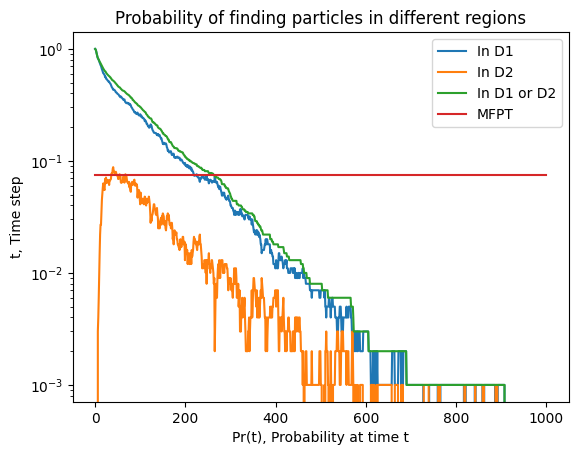

In [38]:
#Probability of finding a particle in medium1 or medium2 or hiting the target
count1 = np.zeros(nums)
count2 = np.zeros(nums)
count3 = np.zeros(nums)
for t in range(nums):
  for p in range(nump):
    count3[t] += np.count_nonzero((0 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R))
    count1[t] += np.count_nonzero((R < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R1))
    count2[t] += np.count_nonzero((R1 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R2))

xticks = np.linspace(1/nums, 1, nums)
yticks = np.linspace(1/nums, 1, nums)
plt.yscale("log")
plt.plot(count1/nump)
plt.plot(count2/nump)
plt.plot((count1 + count2)/nump)
plt.plot(np.tile(MFPT/nums, nums))
#plt.plot(count3/nump)
plt.legend(["In D1", "In D2", "In D1 or D2", "MFPT", "Hit target"])
plt.ylabel("t, Time step")
plt.xlabel("Pr(t), Probability at time t")
plt.title("Probability of finding particles in different regions")
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Prob_Strat_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

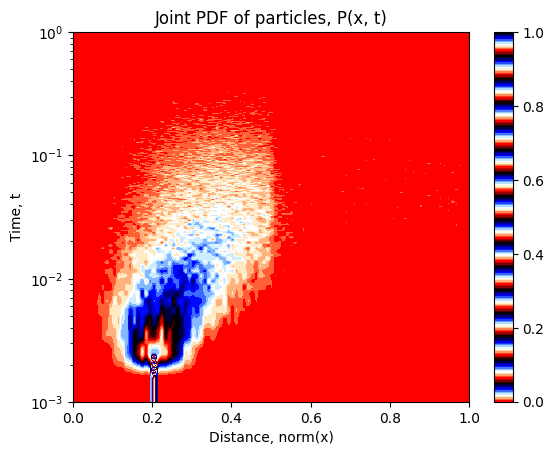

In [39]:
#Plot a heatmap of probability of particles
gridX = 100
gridT = nums
pos = np.round(np.linspace(0, 1, gridX + 1), 2)
tim = np.linspace(0, gridT, gridT+1)
PDF1D = np.zeros((gridT, gridX+1))

#Derive a heatmap of the particles
#Find the norm of particles at each time step
Z = np.linalg.norm(Y/R2, axis=0)

#Quantize it to 2 ( = log10(gridX)) decimal places as grix X is with such precision
Z = np.round(Z, 2)

for t in range(nums):
#position of all particles at time t
  for p in range(len(pos)):
    PDF1D[t][p] = np.count_nonzero(Z[t, :] == pos[p])

#Plot the heatmap of pdf
plt.title("Joint PDF of particles, P(x, t)")
#PDF1D is a 2D matrix with (0,0)th element on top left. Fip vertically
plt.yscale('log')
plt.imshow(np.flipud(PDF1D/nump), cmap = 'flag', extent = [0, 1, dt, dt*nums], aspect = "auto")
plt.xlabel("Distance, norm(x)")
plt.ylabel("Time, t")
plt.colorbar()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Heat_Strat_{nump}_{nums}_{D1}_{D2}.png')
#https://stackoverflow.com/questions/2546475/how-can-i-draw-a-log-normalized-imshow-plot-with-a-colorbar-representing-the-raw

# Simulate Isothermal Convention

In [40]:
#Hitting times if the target is hit
hittingTime = np.zeros(nump)
#Trajectory of a particle
X = np.zeros([dim, nums])
#Trajectories of all particles
Y = np.zeros([dim, nums, nump])


start_time = time.time()
for i in range(nump):
  #Initialize - The particle starts at a random positio outside the target
  if dim == 1:
    X[:, 0] = Init1D[i]
  elif dim == 2:
    X[:, 0] = Init2D[:, i]
  elif dim == 3:
    X[:, 0] = Init3D[:, i]

  #Find particle trajectories
  for j in range(1, nums):
    #Random increment in the position
    dRand = Eps[i, j, :]
    #Increment if particle is in medium1
    dX1 = dX1s[i, j, :]
    #Increment if particle is in medium2
    dX2 = dX2s[i, j, :]

    #Particle hits the target
    if R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) < R:
      X[:, j] = X[:, j - 1] + dX1
      X[:, j+1:] = -1
      hittingTime[i] = j
      break

    #Particle travels in medium1, without hitting the target
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and R < np.linalg.norm(X[:, j - 1] + dX1) < R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle is traveling in medium2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and R1 < np.linalg.norm(X[:, j - 1] + dX2) < R2:
      X[:, j] = X[:, j - 1] + dX2

    #Particle is reflected by the outer ball when its next step crosses the bound R2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) > R2:
      #Find the point of reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) + np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R2**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Image in D2
      X[:, j] = X[:, j - 1] + dX2 - 2*(1 - lamb)*np.dot(dX2, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

    #Particle diffuses from D1 to D2 with a one sided reflection coefficient
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) > R1:
      #Find the point of diffusion/reflection
      lamb = ( -np.dot(X[:, j - 1], dX1) + np.sqrt(np.dot(X[:, j - 1], dX1)**2 - (np.linalg.norm(dX1)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX1)**2)
      r0 = X[:, j - 1] + lamb*dX1
      if any(np.linalg.norm(r0 - poreCenters, axis=1) < r):
        #If particle's projection on surface of the inner ball is near any pore, diffuse to D2.
        if bernoulli.rvs(min(1, math.sqrt(D2/D1))):
          #Diffuse with time-splitting, if the random variable generated is 1
          #Residence times in each medium
          dt1 = (np.linalg.norm(lamb*dX1)/(np.linalg.norm(dRand)*np.sqrt(2*D1)))**2
          dt2 = ((1 - np.sqrt(dt1/dt))**2)*dt
          #Particle diffuses, increment by motion in D2
          X[:, j] = r0 + np.sqrt(2*D2*dt2)*dRand
        else:
          #Reflect, if the random variable generated is 0
          X[:, j] = X[:, j - 1] + dX1 - 2*(1-lamb)*np.dot(dX1, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)
      else:
          #Reflect particle is far from all pores
          X[:, j] = X[:, j - 1] + dX1 - 2*(1-lamb)*np.dot(dX1, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)

    #Particle diffuses from D2 to D1 with a one sided reflection coefficient
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) < R1:
      #Find the point of diffusion/reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) - np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      if any(np.linalg.norm(r0 - poreCenters, axis=1) < r):
        #If particle's projection on surface of the inner ball is near any pore, diffuse to D2.
        if bernoulli.rvs(min(1, math.sqrt(D1/D2))):
          #Diffuse with time-splitting, if the random variable generated is 1
          #Residence times in each medium
          dt2 = (np.linalg.norm(lamb*dX2)/(np.linalg.norm(dRand)*np.sqrt(2*D2)))**2
          dt1 = ((1 - np.sqrt(dt2/dt))**2)*dt
          #Particle diffuses, increment by motion in D1
          X[:, j] = r0 + np.sqrt(2*D1*dt1)*dRand
        else:
          #Reflect, if the random variable generated is 0
          X[:, j] = X[:, j - 1] + dX2 - 2*(1-lamb)*np.dot(dX2, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)
      else:
          #Reflect, if projection is far from all pores
          X[:, j] = X[:, j - 1] + dX2 - 2*(1-lamb)*np.dot(dX2, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)

  #Save the particle's trajectory
  Y[:, :, i] = X
  #print(i)

#Time taken to simulate motion of nump particles each taking nums steps
print("nump = ", nump, "nums = ", nums, "--- %s seconds ---" % (time.time() - start_time))

nump =  1000 nums =  1000 --- 8.76245379447937 seconds ---


# Plots

Mean First Passage Time =  72.35840188014102


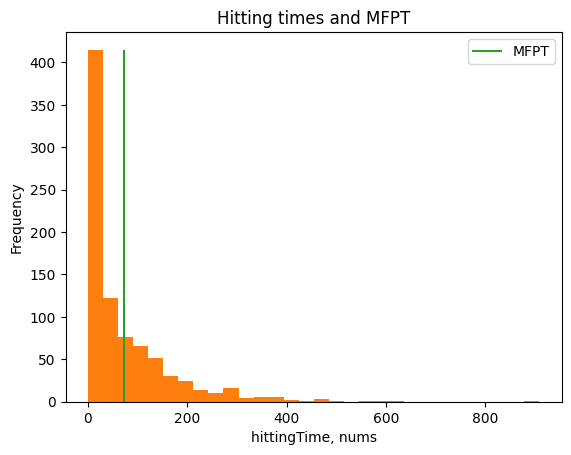

In [41]:
#Histogram hitting times and plot MFPT
hit = hittingTime[hittingTime != 0]
#Should zero be removed for MFPT calculation?
MFPT = np.average(hit)
print("Mean First Passage Time = ", MFPT)
plt.plot(np.tile(MFPT, int(max(plt.hist(hit, 30)[0]))), range(int(max(plt.hist(hit, 30)[0]))), label="MFPT")
#plt.hist(hit, 30, label="Zero removed")
#plt.hist(hittingTime, 30, label="Zero inflated")
plt.ylabel("Frequency")
plt.xlabel("hittingTime, nums")
plt.title("Hitting times and MFPT")
plt.legend()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Hist_Iso_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

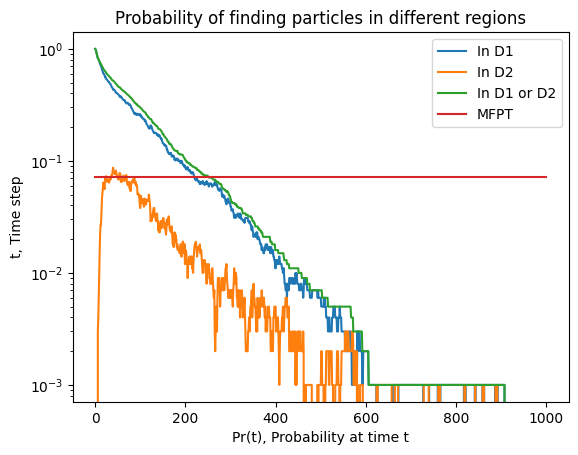

In [42]:
#Probability of finding a particle in medium1 or medium2 or hiting the target
count1 = np.zeros(nums)
count2 = np.zeros(nums)
count3 = np.zeros(nums)
for t in range(nums):
  for p in range(nump):
    count3[t] += np.count_nonzero((0 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R))
    count1[t] += np.count_nonzero((R < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R1))
    count2[t] += np.count_nonzero((R1 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R2))

xticks = np.linspace(1/nums, 1, nums)
yticks = np.linspace(1/nums, 1, nums)
plt.yscale("log")
plt.plot(count1/nump)
plt.plot(count2/nump)
plt.plot((count1 + count2)/nump)
plt.plot(np.tile(MFPT/nums, nums))
#plt.plot(count3/nump)
plt.legend(["In D1", "In D2", "In D1 or D2", "MFPT", "Hit target"])
plt.ylabel("t, Time step")
plt.xlabel("Pr(t), Probability at time t")
plt.title("Probability of finding particles in different regions")
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Prob_Iso_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

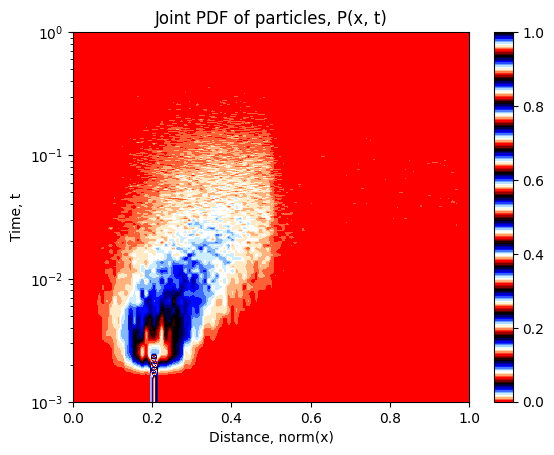

In [43]:
#Plot a heatmap of probability of particles
gridX = 100
gridT = nums
pos = np.round(np.linspace(0, 1, gridX + 1), 2)
tim = np.linspace(0, gridT, gridT+1)
PDF1D = np.zeros((gridT, gridX+1))

#Derive a heatmap of the particles
#Find the norm of particles at each time step
Z = np.linalg.norm(Y/R2, axis=0)

#Quantize it to 2 ( = log10(gridX)) decimal places as grix X is with such precision
Z = np.round(Z, 2)

for t in range(nums):
#position of all particles at time t
  for p in range(len(pos)):
    PDF1D[t][p] = np.count_nonzero(Z[t, :] == pos[p])

#Plot the heatmap of pdf
plt.title("Joint PDF of particles, P(x, t)")
#PDF1D is a 2D matrix with (0,0)th element on top left. Fip vertically
plt.yscale('log')
plt.imshow(np.flipud(PDF1D/nump), cmap = 'flag', extent = [0, 1, dt, dt*nums], aspect = "auto")
plt.xlabel("Distance, norm(x)")
plt.ylabel("Time, t")
plt.colorbar()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Heat_Ito_{nump}_{nums}_{D1}_{D2}.png')

# D1 = 1, D2 = 1

#Simulate Ito Convention

In [44]:
#Diffusivity of inner medium
D1 = 1
#Diffusivity of outer medium
D2 = 1

#Hitting times if the target is hit
hittingTime = np.zeros(nump)
#Trajectory of a particle
X = np.zeros([dim, nums])
#Trajectories of all particles
Y = np.zeros([dim, nums, nump])

In [45]:
start_time = time.time()
for i in range(nump):
  #Initialize - The particle starts at a random position outside the target
  if dim == 1:
    X[:, 0] = Init1D[i]
  if dim == 2:
    X[:, 0] = Init2D[:, i]
  elif dim == 3:
    X[:, 0] = Init3D[:, i]

  #Find particle trajectories
  for j in range(1, nums):
    #Random increment in the position
    dRand = Eps[i, j, :]
    #Increment if particle is in medium1
    dX1 = dX1s[i, j, :]
    #Increment if particle is in medium2
    dX2 = dX2s[i, j, :]

    #Particle hits the target
    if R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) < R:
      X[:, j] = X[:, j - 1] + dX1
      #For plotting
      hittingTime[i] = j
      """TODO - How to remove the particle once it hits the target?"""
      X[:, j+1:] = -1
      #print(j, "Hit", X[:, j], np.linalg.norm(X[:, j]), np.linalg.norm(X[:, j] - X[:, j-1]))
      break

    #Particle is traveling in medium1 outside the target
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and R < np.linalg.norm(X[:, j - 1] + dX1) < R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle is traveling in medium2, without hitting the reflecting boundary
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and R1 < np.linalg.norm(X[:, j - 1] + dX2) < R2:
      X[:, j] = X[:, j - 1] + dX2

    #Particle is reflected by the outer ball when its next step crosses the bound R2 - Reflect in D2
    #https://math.stackexchange.com/questions/13261/how-to-get-a-reflection-vector
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) > R2:
      #Find the point of reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) + np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R2**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Image in D2
      X[:, j] = X[:, j - 1] + dX2 - 2*(1-lamb)*np.dot(dX2, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)

    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) > R1:
      #Find the point of reflection/diffusion
      lamb = ( -np.dot(X[:, j - 1], dX1) + np.sqrt(np.dot(X[:, j - 1], dX1)**2 - (np.linalg.norm(dX1)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX1)**2)
      r0 = X[:, j - 1] + lamb*dX1
      if any(np.linalg.norm(r0 - poreCenters, axis=1) < r):
        #If particle's projection on surface of the inner ball is near any pore, diffuse to D2.
        X[:, j] = X[:, j - 1] + dX1
      else:
        #Particle is reflected by inner ball when it's near the media boundary and far from all the pores
        #Image in D1
        X[:, j] = X[:, j - 1] + dX1 - 2*(1-lamb)*np.dot(dX1, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)
        #print(j, "Reflection in D1", X[:, j], np.linalg.norm(X[:, j]), np.linalg.norm(X[:, j] - X[:, j-1]))

    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) < R1:
      #Find the point of reflection/diffusion
      lamb = ( -np.dot(X[:, j - 1], dX2) - np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #If particle projected on surface of ball 1 is near a pore, diffuse to D1. Else reflect it
      if any(np.linalg.norm(r0 - poreCenters, axis=1) < r):
        #Diffuse to D1 via a pore
        X[:, j] = X[:, j - 1] + dX1
      else:
        #Reflect - Image in D2
        X[:, j] = X[:, j - 1] + dX2 - 2*(1-lamb)*np.dot(dX2, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)
        #print(j, "Reflection in D2", X[:, j], np.linalg.norm(X[:, j]), np.linalg.norm(X[:, j] - X[:, j-1]))
  #Save the particle's trajectory
  Y[:, :, i] = X
  #print(i)

#Time taken to simulate motion of nump particles each taking nums steps
print("nump = ", nump, "nums = ", nums, "--- %s seconds ---" % (time.time() - start_time))

nump =  1000 nums =  1000 --- 13.47156548500061 seconds ---


# Plots

Mean First Passage Time =  63.605228758169936


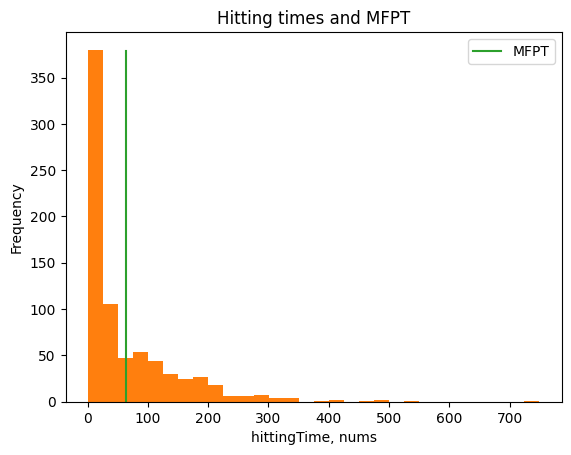

In [46]:
#Histogram hitting times and plot MFPT
hit = hittingTime[hittingTime != 0]
#Should zero be removed for MFPT calculation?
MFPT = np.average(hit)
print("Mean First Passage Time = ", MFPT)
plt.plot(np.tile(MFPT, int(max(plt.hist(hit, 30)[0]))), range(int(max(plt.hist(hit, 30)[0]))), label="MFPT")
#plt.hist(hit, 30, label="Zero removed")
#plt.hist(hittingTime, 30, label="Zero inflated")
plt.ylabel("Frequency")
plt.xlabel("hittingTime, nums")
plt.title("Hitting times and MFPT")
plt.legend()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Hist_Ito_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

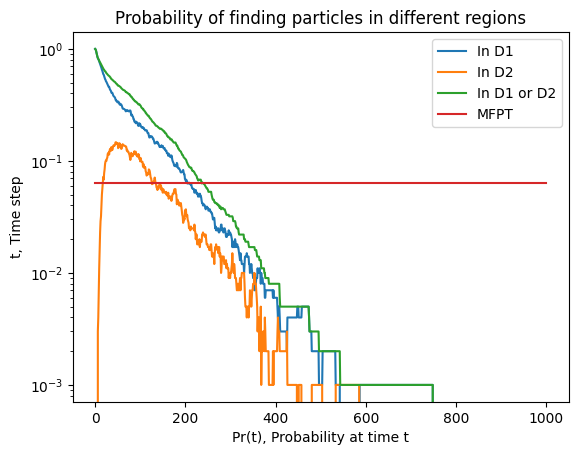

In [47]:
#Probability of finding a particle in medium1 or medium2 or hiting the target
count1 = np.zeros(nums)
count2 = np.zeros(nums)
count3 = np.zeros(nums)
for t in range(nums):
  for p in range(nump):
    count3[t] += np.count_nonzero((0 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R))
    count1[t] += np.count_nonzero((R < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R1))
    count2[t] += np.count_nonzero((R1 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R2))

xticks = np.linspace(1/nums, 1, nums)
yticks = np.linspace(1/nums, 1, nums)
plt.yscale("log")
plt.plot(count1/nump)
plt.plot(count2/nump)
plt.plot((count1 + count2)/nump)
plt.plot(np.tile(MFPT/nums, nums))
#plt.plot(count3/nump)
plt.legend(["In D1", "In D2", "In D1 or D2", "MFPT", "Hit target"])
plt.ylabel("t, Time step")
plt.xlabel("Pr(t), Probability at time t")
plt.title("Probability of finding particles in different regions")
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Prob_Ito_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

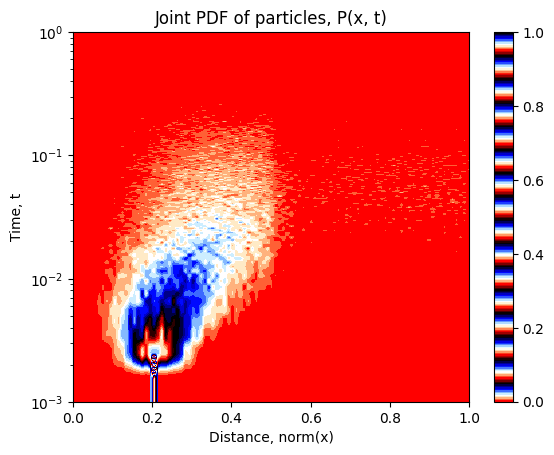

In [48]:
#Plot a heatmap of probability of particles
gridX = 100
gridT = nums
pos = np.round(np.linspace(0, 1, gridX + 1), 2)
tim = np.linspace(0, gridT, gridT+1)
PDF1D = np.zeros((gridT, gridX+1))

#Derive a heatmap of the particles
#Find the norm of particles at each time step
Z = np.linalg.norm(Y/R2, axis=0)

#Quantize it to 2 ( = log10(gridX)) decimal places as grix X is with such precision
Z = np.round(Z, 2)

for t in range(nums):
#position of all particles at time t
  for p in range(len(pos)):
    PDF1D[t][p] = np.count_nonzero(Z[t, :] == pos[p])

#Plot the heatmap of pdf
plt.title("Joint PDF of particles, P(x, t)")
#PDF1D is a 2D matrix with (0,0)th element on top left. Fip vertically
plt.yscale('log')
plt.imshow(np.flipud(PDF1D/nump), cmap = 'flag', extent = [0, 1, dt, dt*nums], aspect = "auto")
plt.xlabel("Distance, norm(x)")
plt.ylabel("Time, t")
plt.colorbar()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Heat_Ito_{nump}_{nums}_{D1}_{D2}.png')

#Simulate Stratonovich Convention

In [49]:
#Hitting times if the target is hit
hittingTime = np.zeros(nump)
#Trajectory of a particle
X = np.zeros([dim, nums])
#Trajectories of all particles
Y = np.zeros([dim, nums, nump])


start_time = time.time()
for i in range(nump):
  #Initialize - The particle starts at a random positio outside the target
  if dim == 1:
    X[:, 0] = Init1D[i]
  elif dim == 2:
    X[:, 0] = Init2D[:, i]
  elif dim == 3:
    X[:, 0] = Init3D[:, i]

  #Find particle trajectories
  for j in range(1, nums):
    #Random increment in the position
    dRand = Eps[i, j, :]
    #Increment if particle is in medium1
    dX1 = dX1s[i, j, :]
    #Increment if particle is in medium2
    dX2 = dX2s[i, j, :]

    #Particle travels in medium1, without hitting the target
    if R < np.linalg.norm(X[:, j - 1]) < R1 and R < np.linalg.norm(X[:, j - 1] + dX1) < R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle is traveling in medium2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and R1 < np.linalg.norm(X[:, j - 1] + dX2) < R2:
      X[:, j] = X[:, j - 1] + dX2

    #Particle is reflected by the outer ball when its next step crosses the bound R2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) > R2:
      #Find the point of reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) + np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R2**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Image in D2
      X[:, j] = X[:, j - 1] + dX2 - 2*(1 - lamb)*np.dot(dX2, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) > R1:
      #Find the point of reflection/diffusion
      lamb = ( -np.dot(X[:, j - 1], dX1) + np.sqrt(np.dot(X[:, j - 1], dX1)**2 - (np.linalg.norm(dX1)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX1)**2)
      r0 = X[:, j - 1] + lamb*dX1
      if any(np.linalg.norm(r0 - poreCenters, axis=1) < r):
        #If particle's projection on surface of the inner ball is near any pore, diffuse to D2.
        #Residence times in each medium
        dt1 = (np.linalg.norm(lamb*dX1)/(np.linalg.norm(dRand)*np.sqrt(2*D1)))**2
        dt2 = ((1 - np.sqrt(dt1/dt))**2)*dt
        #Particle diffuses, increment by motion in D2
        X[:, j] = r0 + np.sqrt(2*D2*dt2)*dRand
        #print(j, "Diffusion from D1 to D2", dt1, dt2, dt, X[:, j], np.linalg.norm(X[:, j]), np.linalg.norm(X[:, j] - X[:, j-1]))
        #print(X[:, j-1])
        #print(X[:, j])
      else:
        #Particle is reflected by inner ball when it's near the media boundary and far from all the pores
        #Image in D1
        X[:, j] = X[:, j - 1] + dX1 - 2*(1-lamb)*np.dot(dX1, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)
        #print(j, "Reflection in D1", X[:, j], np.linalg.norm(X[:, j]), np.linalg.norm(X[:, j] - X[:, j-1]))

    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) < R1:
      #Find the point of reflection/diffusion
      lamb = ( -np.dot(X[:, j - 1], dX2) - np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #If particle projected on surface of ball 1 is near a pore, diffuse to D1. Else reflect it
      if any(np.linalg.norm(r0 - poreCenters, axis=1) < r):
        #Residence times in each medium
        dt2 = (np.linalg.norm(lamb*dX2)/(np.linalg.norm(dRand)*np.sqrt(2*D2)))**2
        dt1 = ((1 - np.sqrt(dt2/dt))**2)*dt
        #Particle diffuses, increment by motion in D1
        X[:, j] = r0 + np.sqrt(2*D1*dt1)*dRand
        #print(j, "Diffusion from D2 to D1", dt1, dt2, dt, X[:, j], np.linalg.norm(X[:, j]), np.linalg.norm(X[:, j] - X[:, j-1]))
      else:
        #Image in D2
        X[:, j] = X[:, j - 1] + dX2 - 2*(1-lamb)*np.dot(dX2, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)
        #print(j, "Reflection in D2", X[:, j], np.linalg.norm(X[:, j]), np.linalg.norm(X[:, j] - X[:, j-1]))

    #Particle hits the target
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) < R:
      X[:, j] = X[:, j - 1] + dX1
      X[:, j+1:] = -1
      hittingTime[i] = j
      break

  #Save the particle's trajectory
  Y[:, :, i] = X
  #print(i)

#Time taken to simulate motion of nump particles each taking nums steps
print("nump = ", nump, "nums = ", nums, "--- %s seconds ---" % (time.time() - start_time))

nump =  1000 nums =  1000 --- 8.940979957580566 seconds ---


# Plots

Mean First Passage Time =  73.56235565819861


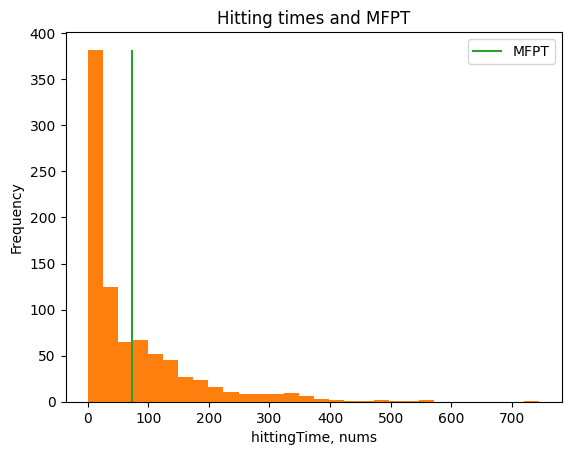

In [50]:
#Histogram hitting times and plot MFPT
hit = hittingTime[hittingTime != 0]
#Should zero be removed for MFPT calculation?
MFPT = np.average(hit)
print("Mean First Passage Time = ", MFPT)
plt.plot(np.tile(MFPT, int(max(plt.hist(hit, 30)[0]))), range(int(max(plt.hist(hit, 30)[0]))), label="MFPT")
#plt.hist(hit, 30, label="Zero removed")
#plt.hist(hittingTime, 30, label="Zero inflated")
plt.ylabel("Frequency")
plt.xlabel("hittingTime, nums")
plt.title("Hitting times and MFPT")
plt.legend()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Hist_Strat_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

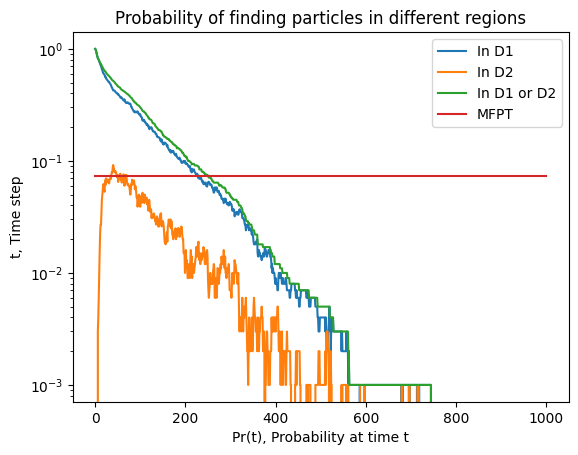

In [51]:
#Probability of finding a particle in medium1 or medium2 or hiting the target
count1 = np.zeros(nums)
count2 = np.zeros(nums)
count3 = np.zeros(nums)
for t in range(nums):
  for p in range(nump):
    count3[t] += np.count_nonzero((0 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R))
    count1[t] += np.count_nonzero((R < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R1))
    count2[t] += np.count_nonzero((R1 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R2))

xticks = np.linspace(1/nums, 1, nums)
yticks = np.linspace(1/nums, 1, nums)
plt.yscale("log")
plt.plot(count1/nump)
plt.plot(count2/nump)
plt.plot((count1 + count2)/nump)
plt.plot(np.tile(MFPT/nums, nums))
#plt.plot(count3/nump)
plt.legend(["In D1", "In D2", "In D1 or D2", "MFPT", "Hit target"])
plt.ylabel("t, Time step")
plt.xlabel("Pr(t), Probability at time t")
plt.title("Probability of finding particles in different regions")
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Prob_Strat_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

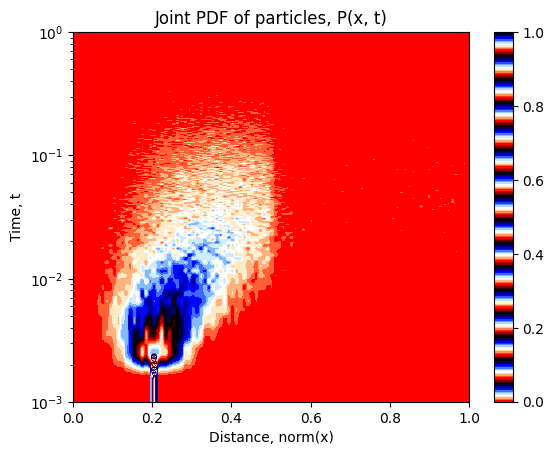

In [52]:
#Plot a heatmap of probability of particles
gridX = 100
gridT = nums
pos = np.round(np.linspace(0, 1, gridX + 1), 2)
tim = np.linspace(0, gridT, gridT+1)
PDF1D = np.zeros((gridT, gridX+1))

#Derive a heatmap of the particles
#Find the norm of particles at each time step
Z = np.linalg.norm(Y/R2, axis=0)

#Quantize it to 2 ( = log10(gridX)) decimal places as grix X is with such precision
Z = np.round(Z, 2)

for t in range(nums):
#position of all particles at time t
  for p in range(len(pos)):
    PDF1D[t][p] = np.count_nonzero(Z[t, :] == pos[p])

#Plot the heatmap of pdf
plt.title("Joint PDF of particles, P(x, t)")
#PDF1D is a 2D matrix with (0,0)th element on top left. Fip vertically
plt.yscale('log')
plt.imshow(np.flipud(PDF1D/nump), cmap = 'flag', extent = [0, 1, dt, dt*nums], aspect = "auto")
plt.xlabel("Distance, norm(x)")
plt.ylabel("Time, t")
plt.colorbar()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Heat_Strat_{nump}_{nums}_{D1}_{D2}.png')
#https://stackoverflow.com/questions/2546475/how-can-i-draw-a-log-normalized-imshow-plot-with-a-colorbar-representing-the-raw

# Simulate Isothermal Convention

In [53]:
#Hitting times if the target is hit
hittingTime = np.zeros(nump)
#Trajectory of a particle
X = np.zeros([dim, nums])
#Trajectories of all particles
Y = np.zeros([dim, nums, nump])


start_time = time.time()
for i in range(nump):
  #Initialize - The particle starts at a random positio outside the target
  if dim == 1:
    X[:, 0] = Init1D[i]
  elif dim == 2:
    X[:, 0] = Init2D[:, i]
  elif dim == 3:
    X[:, 0] = Init3D[:, i]

  #Find particle trajectories
  for j in range(1, nums):
    #Random increment in the position
    dRand = Eps[i, j, :]
    #Increment if particle is in medium1
    dX1 = dX1s[i, j, :]
    #Increment if particle is in medium2
    dX2 = dX2s[i, j, :]

    #Particle hits the target
    if R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) < R:
      X[:, j] = X[:, j - 1] + dX1
      X[:, j+1:] = -1
      hittingTime[i] = j
      break

    #Particle travels in medium1, without hitting the target
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and R < np.linalg.norm(X[:, j - 1] + dX1) < R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle is traveling in medium2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and R1 < np.linalg.norm(X[:, j - 1] + dX2) < R2:
      X[:, j] = X[:, j - 1] + dX2

    #Particle is reflected by the outer ball when its next step crosses the bound R2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) > R2:
      #Find the point of reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) + np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R2**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Image in D2
      X[:, j] = X[:, j - 1] + dX2 - 2*(1 - lamb)*np.dot(dX2, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

    #Particle diffuses from D1 to D2 with a one sided reflection coefficient
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) > R1:
      #Find the point of diffusion/reflection
      lamb = ( -np.dot(X[:, j - 1], dX1) + np.sqrt(np.dot(X[:, j - 1], dX1)**2 - (np.linalg.norm(dX1)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX1)**2)
      r0 = X[:, j - 1] + lamb*dX1
      if any(np.linalg.norm(r0 - poreCenters, axis=1) < r):
        #If particle's projection on surface of the inner ball is near any pore, diffuse to D2.
        if bernoulli.rvs(min(1, math.sqrt(D2/D1))):
          #Diffuse with time-splitting, if the random variable generated is 1
          #Residence times in each medium
          dt1 = (np.linalg.norm(lamb*dX1)/(np.linalg.norm(dRand)*np.sqrt(2*D1)))**2
          dt2 = ((1 - np.sqrt(dt1/dt))**2)*dt
          #Particle diffuses, increment by motion in D2
          X[:, j] = r0 + np.sqrt(2*D2*dt2)*dRand
        else:
          #Reflect, if the random variable generated is 0
          X[:, j] = X[:, j - 1] + dX1 - 2*(1-lamb)*np.dot(dX1, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)
      else:
          #Reflect particle is far from all pores
          X[:, j] = X[:, j - 1] + dX1 - 2*(1-lamb)*np.dot(dX1, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)

    #Particle diffuses from D2 to D1 with a one sided reflection coefficient
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) < R1:
      #Find the point of diffusion/reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) - np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      if any(np.linalg.norm(r0 - poreCenters, axis=1) < r):
        #If particle's projection on surface of the inner ball is near any pore, diffuse to D2.
        if bernoulli.rvs(min(1, math.sqrt(D1/D2))):
          #Diffuse with time-splitting, if the random variable generated is 1
          #Residence times in each medium
          dt2 = (np.linalg.norm(lamb*dX2)/(np.linalg.norm(dRand)*np.sqrt(2*D2)))**2
          dt1 = ((1 - np.sqrt(dt2/dt))**2)*dt
          #Particle diffuses, increment by motion in D1
          X[:, j] = r0 + np.sqrt(2*D1*dt1)*dRand
        else:
          #Reflect, if the random variable generated is 0
          X[:, j] = X[:, j - 1] + dX2 - 2*(1-lamb)*np.dot(dX2, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)
      else:
          #Reflect, if projection is far from all pores
          X[:, j] = X[:, j - 1] + dX2 - 2*(1-lamb)*np.dot(dX2, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)

  #Save the particle's trajectory
  Y[:, :, i] = X
  #print(i)

#Time taken to simulate motion of nump particles each taking nums steps
print("nump = ", nump, "nums = ", nums, "--- %s seconds ---" % (time.time() - start_time))

nump =  1000 nums =  1000 --- 9.309311151504517 seconds ---


# Plots

Mean First Passage Time =  73.56235565819861


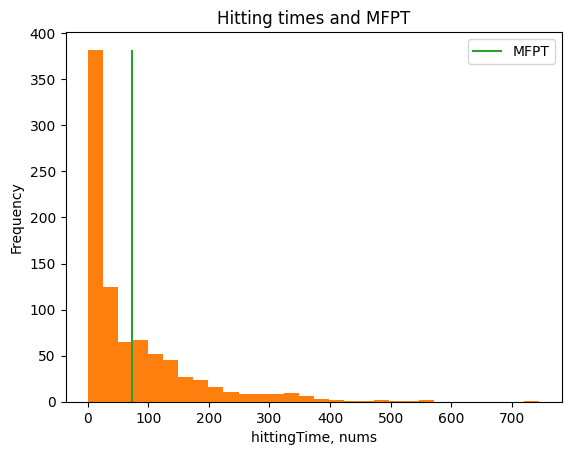

In [54]:
#Histogram hitting times and plot MFPT
hit = hittingTime[hittingTime != 0]
#Should zero be removed for MFPT calculation?
MFPT = np.average(hit)
print("Mean First Passage Time = ", MFPT)
plt.plot(np.tile(MFPT, int(max(plt.hist(hit, 30)[0]))), range(int(max(plt.hist(hit, 30)[0]))), label="MFPT")
#plt.hist(hit, 30, label="Zero removed")
#plt.hist(hittingTime, 30, label="Zero inflated")
plt.ylabel("Frequency")
plt.xlabel("hittingTime, nums")
plt.title("Hitting times and MFPT")
plt.legend()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Hist_Iso_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

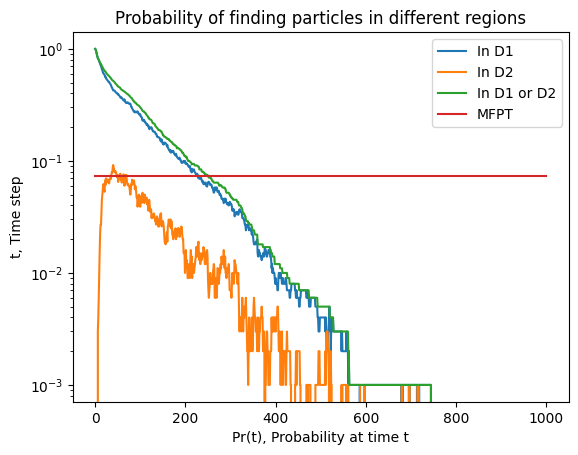

In [55]:
#Probability of finding a particle in medium1 or medium2 or hiting the target
count1 = np.zeros(nums)
count2 = np.zeros(nums)
count3 = np.zeros(nums)
for t in range(nums):
  for p in range(nump):
    count3[t] += np.count_nonzero((0 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R))
    count1[t] += np.count_nonzero((R < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R1))
    count2[t] += np.count_nonzero((R1 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R2))

xticks = np.linspace(1/nums, 1, nums)
yticks = np.linspace(1/nums, 1, nums)
plt.yscale("log")
plt.plot(count1/nump)
plt.plot(count2/nump)
plt.plot((count1 + count2)/nump)
plt.plot(np.tile(MFPT/nums, nums))
#plt.plot(count3/nump)
plt.legend(["In D1", "In D2", "In D1 or D2", "MFPT", "Hit target"])
plt.ylabel("t, Time step")
plt.xlabel("Pr(t), Probability at time t")
plt.title("Probability of finding particles in different regions")
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Prob_Iso_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

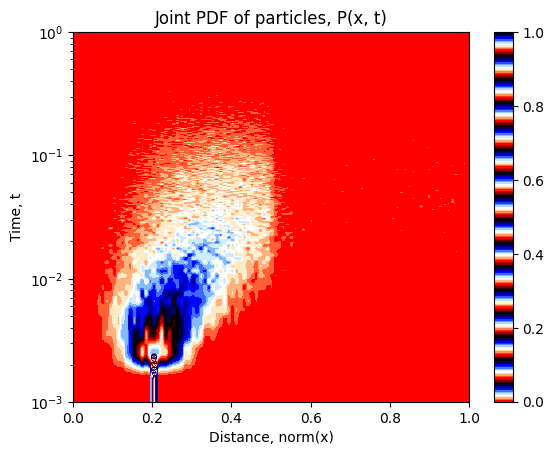

In [56]:
#Plot a heatmap of probability of particles
gridX = 100
gridT = nums
pos = np.round(np.linspace(0, 1, gridX + 1), 2)
tim = np.linspace(0, gridT, gridT+1)
PDF1D = np.zeros((gridT, gridX+1))

#Derive a heatmap of the particles
#Find the norm of particles at each time step
Z = np.linalg.norm(Y/R2, axis=0)

#Quantize it to 2 ( = log10(gridX)) decimal places as grix X is with such precision
Z = np.round(Z, 2)

for t in range(nums):
#position of all particles at time t
  for p in range(len(pos)):
    PDF1D[t][p] = np.count_nonzero(Z[t, :] == pos[p])

#Plot the heatmap of pdf
plt.title("Joint PDF of particles, P(x, t)")
#PDF1D is a 2D matrix with (0,0)th element on top left. Fip vertically
plt.yscale('log')
plt.imshow(np.flipud(PDF1D/nump), cmap = 'flag', extent = [0, 1, dt, dt*nums], aspect = "auto")
plt.xlabel("Distance, norm(x)")
plt.ylabel("Time, t")
plt.colorbar()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Heat_Ito_{nump}_{nums}_{D1}_{D2}.png')

# D1 = 1.1, D2 = 1

#Simulate Ito Convention

In [57]:
#Diffusivity of inner medium
D1 = 1.1
#Diffusivity of outer medium
D2 = 1

#Hitting times if the target is hit
hittingTime = np.zeros(nump)
#Trajectory of a particle
X = np.zeros([dim, nums])
#Trajectories of all particles
Y = np.zeros([dim, nums, nump])

In [58]:
start_time = time.time()
for i in range(nump):
  #Initialize - The particle starts at a random position outside the target
  if dim == 1:
    X[:, 0] = Init1D[i]
  if dim == 2:
    X[:, 0] = Init2D[:, i]
  elif dim == 3:
    X[:, 0] = Init3D[:, i]

  #Find particle trajectories
  for j in range(1, nums):
    #Random increment in the position
    dRand = Eps[i, j, :]
    #Increment if particle is in medium1
    dX1 = dX1s[i, j, :]
    #Increment if particle is in medium2
    dX2 = dX2s[i, j, :]

    #Particle hits the target
    if R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) < R:
      X[:, j] = X[:, j - 1] + dX1
      #For plotting
      hittingTime[i] = j
      """TODO - How to remove the particle once it hits the target?"""
      X[:, j+1:] = -1
      #print(j, "Hit", X[:, j], np.linalg.norm(X[:, j]), np.linalg.norm(X[:, j] - X[:, j-1]))
      break

    #Particle is traveling in medium1 outside the target
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and R < np.linalg.norm(X[:, j - 1] + dX1) < R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle is traveling in medium2, without hitting the reflecting boundary
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and R1 < np.linalg.norm(X[:, j - 1] + dX2) < R2:
      X[:, j] = X[:, j - 1] + dX2

    #Particle is reflected by the outer ball when its next step crosses the bound R2 - Reflect in D2
    #https://math.stackexchange.com/questions/13261/how-to-get-a-reflection-vector
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) > R2:
      #Find the point of reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) + np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R2**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Image in D2
      X[:, j] = X[:, j - 1] + dX2 - 2*(1-lamb)*np.dot(dX2, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)

    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) > R1:
      #Find the point of reflection/diffusion
      lamb = ( -np.dot(X[:, j - 1], dX1) + np.sqrt(np.dot(X[:, j - 1], dX1)**2 - (np.linalg.norm(dX1)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX1)**2)
      r0 = X[:, j - 1] + lamb*dX1
      if any(np.linalg.norm(r0 - poreCenters, axis=1) < r):
        #If particle's projection on surface of the inner ball is near any pore, diffuse to D2.
        X[:, j] = X[:, j - 1] + dX1
      else:
        #Particle is reflected by inner ball when it's near the media boundary and far from all the pores
        #Image in D1
        X[:, j] = X[:, j - 1] + dX1 - 2*(1-lamb)*np.dot(dX1, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)
        #print(j, "Reflection in D1", X[:, j], np.linalg.norm(X[:, j]), np.linalg.norm(X[:, j] - X[:, j-1]))

    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) < R1:
      #Find the point of reflection/diffusion
      lamb = ( -np.dot(X[:, j - 1], dX2) - np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #If particle projected on surface of ball 1 is near a pore, diffuse to D1. Else reflect it
      if any(np.linalg.norm(r0 - poreCenters, axis=1) < r):
        #Diffuse to D1 via a pore
        X[:, j] = X[:, j - 1] + dX1
      else:
        #Reflect - Image in D2
        X[:, j] = X[:, j - 1] + dX2 - 2*(1-lamb)*np.dot(dX2, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)
        #print(j, "Reflection in D2", X[:, j], np.linalg.norm(X[:, j]), np.linalg.norm(X[:, j] - X[:, j-1]))
  #Save the particle's trajectory
  Y[:, :, i] = X
  #print(i)

#Time taken to simulate motion of nump particles each taking nums steps
print("nump = ", nump, "nums = ", nums, "--- %s seconds ---" % (time.time() - start_time))

nump =  1000 nums =  1000 --- 13.448709487915039 seconds ---


# Plots

Mean First Passage Time =  63.605228758169936


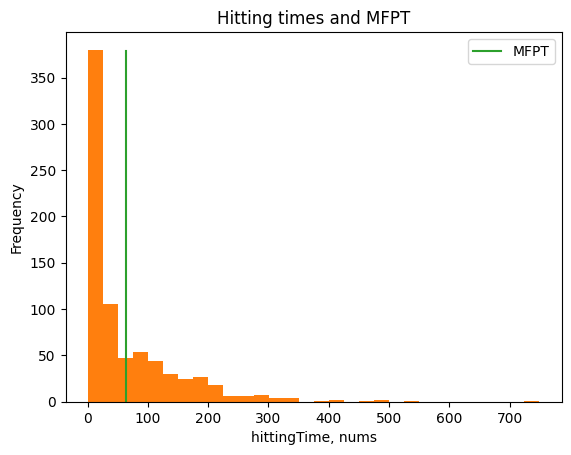

In [59]:
#Histogram hitting times and plot MFPT
hit = hittingTime[hittingTime != 0]
#Should zero be removed for MFPT calculation?
MFPT = np.average(hit)
print("Mean First Passage Time = ", MFPT)
plt.plot(np.tile(MFPT, int(max(plt.hist(hit, 30)[0]))), range(int(max(plt.hist(hit, 30)[0]))), label="MFPT")
#plt.hist(hit, 30, label="Zero removed")
#plt.hist(hittingTime, 30, label="Zero inflated")
plt.ylabel("Frequency")
plt.xlabel("hittingTime, nums")
plt.title("Hitting times and MFPT")
plt.legend()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Hist_Ito_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

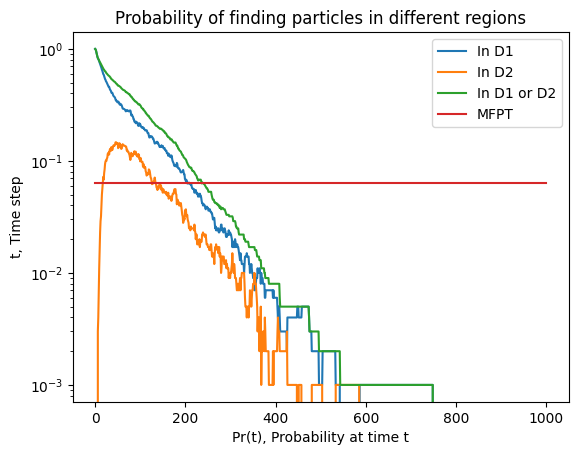

In [60]:
#Probability of finding a particle in medium1 or medium2 or hiting the target
count1 = np.zeros(nums)
count2 = np.zeros(nums)
count3 = np.zeros(nums)
for t in range(nums):
  for p in range(nump):
    count3[t] += np.count_nonzero((0 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R))
    count1[t] += np.count_nonzero((R < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R1))
    count2[t] += np.count_nonzero((R1 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R2))

xticks = np.linspace(1/nums, 1, nums)
yticks = np.linspace(1/nums, 1, nums)
plt.yscale("log")
plt.plot(count1/nump)
plt.plot(count2/nump)
plt.plot((count1 + count2)/nump)
plt.plot(np.tile(MFPT/nums, nums))
#plt.plot(count3/nump)
plt.legend(["In D1", "In D2", "In D1 or D2", "MFPT", "Hit target"])
plt.ylabel("t, Time step")
plt.xlabel("Pr(t), Probability at time t")
plt.title("Probability of finding particles in different regions")
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Prob_Ito_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

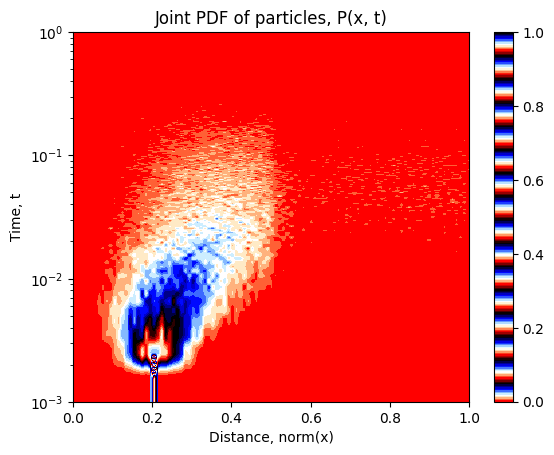

In [61]:
#Plot a heatmap of probability of particles
gridX = 100
gridT = nums
pos = np.round(np.linspace(0, 1, gridX + 1), 2)
tim = np.linspace(0, gridT, gridT+1)
PDF1D = np.zeros((gridT, gridX+1))

#Derive a heatmap of the particles
#Find the norm of particles at each time step
Z = np.linalg.norm(Y/R2, axis=0)

#Quantize it to 2 ( = log10(gridX)) decimal places as grix X is with such precision
Z = np.round(Z, 2)

for t in range(nums):
#position of all particles at time t
  for p in range(len(pos)):
    PDF1D[t][p] = np.count_nonzero(Z[t, :] == pos[p])

#Plot the heatmap of pdf
plt.title("Joint PDF of particles, P(x, t)")
#PDF1D is a 2D matrix with (0,0)th element on top left. Fip vertically
plt.yscale('log')
plt.imshow(np.flipud(PDF1D/nump), cmap = 'flag', extent = [0, 1, dt, dt*nums], aspect = "auto")
plt.xlabel("Distance, norm(x)")
plt.ylabel("Time, t")
plt.colorbar()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Heat_Ito_{nump}_{nums}_{D1}_{D2}.png')

#Simulate Stratonovich Convention

In [62]:
#Hitting times if the target is hit
hittingTime = np.zeros(nump)
#Trajectory of a particle
X = np.zeros([dim, nums])
#Trajectories of all particles
Y = np.zeros([dim, nums, nump])


start_time = time.time()
for i in range(nump):
  #Initialize - The particle starts at a random positio outside the target
  if dim == 1:
    X[:, 0] = Init1D[i]
  elif dim == 2:
    X[:, 0] = Init2D[:, i]
  elif dim == 3:
    X[:, 0] = Init3D[:, i]

  #Find particle trajectories
  for j in range(1, nums):
    #Random increment in the position
    dRand = Eps[i, j, :]
    #Increment if particle is in medium1
    dX1 = dX1s[i, j, :]
    #Increment if particle is in medium2
    dX2 = dX2s[i, j, :]

    #Particle travels in medium1, without hitting the target
    if R < np.linalg.norm(X[:, j - 1]) < R1 and R < np.linalg.norm(X[:, j - 1] + dX1) < R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle is traveling in medium2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and R1 < np.linalg.norm(X[:, j - 1] + dX2) < R2:
      X[:, j] = X[:, j - 1] + dX2

    #Particle is reflected by the outer ball when its next step crosses the bound R2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) > R2:
      #Find the point of reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) + np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R2**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Image in D2
      X[:, j] = X[:, j - 1] + dX2 - 2*(1 - lamb)*np.dot(dX2, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) > R1:
      #Find the point of reflection/diffusion
      lamb = ( -np.dot(X[:, j - 1], dX1) + np.sqrt(np.dot(X[:, j - 1], dX1)**2 - (np.linalg.norm(dX1)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX1)**2)
      r0 = X[:, j - 1] + lamb*dX1
      if any(np.linalg.norm(r0 - poreCenters, axis=1) < r):
        #If particle's projection on surface of the inner ball is near any pore, diffuse to D2.
        #Residence times in each medium
        dt1 = (np.linalg.norm(lamb*dX1)/(np.linalg.norm(dRand)*np.sqrt(2*D1)))**2
        dt2 = ((1 - np.sqrt(dt1/dt))**2)*dt
        #Particle diffuses, increment by motion in D2
        X[:, j] = r0 + np.sqrt(2*D2*dt2)*dRand
        #print(j, "Diffusion from D1 to D2", dt1, dt2, dt, X[:, j], np.linalg.norm(X[:, j]), np.linalg.norm(X[:, j] - X[:, j-1]))
        #print(X[:, j-1])
        #print(X[:, j])
      else:
        #Particle is reflected by inner ball when it's near the media boundary and far from all the pores
        #Image in D1
        X[:, j] = X[:, j - 1] + dX1 - 2*(1-lamb)*np.dot(dX1, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)
        #print(j, "Reflection in D1", X[:, j], np.linalg.norm(X[:, j]), np.linalg.norm(X[:, j] - X[:, j-1]))

    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) < R1:
      #Find the point of reflection/diffusion
      lamb = ( -np.dot(X[:, j - 1], dX2) - np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #If particle projected on surface of ball 1 is near a pore, diffuse to D1. Else reflect it
      if any(np.linalg.norm(r0 - poreCenters, axis=1) < r):
        #Residence times in each medium
        dt2 = (np.linalg.norm(lamb*dX2)/(np.linalg.norm(dRand)*np.sqrt(2*D2)))**2
        dt1 = ((1 - np.sqrt(dt2/dt))**2)*dt
        #Particle diffuses, increment by motion in D1
        X[:, j] = r0 + np.sqrt(2*D1*dt1)*dRand
        #print(j, "Diffusion from D2 to D1", dt1, dt2, dt, X[:, j], np.linalg.norm(X[:, j]), np.linalg.norm(X[:, j] - X[:, j-1]))
      else:
        #Image in D2
        X[:, j] = X[:, j - 1] + dX2 - 2*(1-lamb)*np.dot(dX2, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)
        #print(j, "Reflection in D2", X[:, j], np.linalg.norm(X[:, j]), np.linalg.norm(X[:, j] - X[:, j-1]))

    #Particle hits the target
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) < R:
      X[:, j] = X[:, j - 1] + dX1
      X[:, j+1:] = -1
      hittingTime[i] = j
      break

  #Save the particle's trajectory
  Y[:, :, i] = X
  #print(i)

#Time taken to simulate motion of nump particles each taking nums steps
print("nump = ", nump, "nums = ", nums, "--- %s seconds ---" % (time.time() - start_time))

nump =  1000 nums =  1000 --- 7.996683597564697 seconds ---


# Plots

Mean First Passage Time =  71.19603267211203


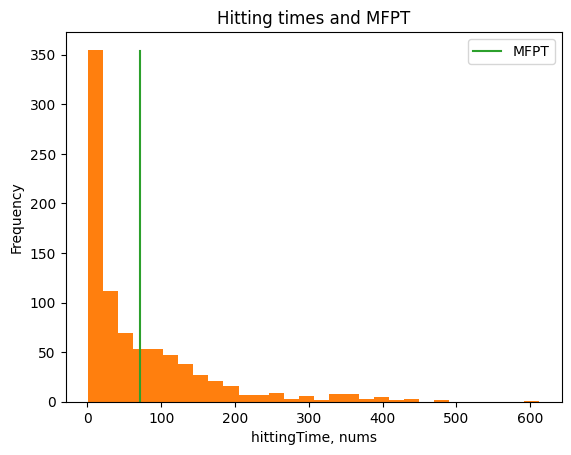

In [63]:
#Histogram hitting times and plot MFPT
hit = hittingTime[hittingTime != 0]
#Should zero be removed for MFPT calculation?
MFPT = np.average(hit)
print("Mean First Passage Time = ", MFPT)
plt.plot(np.tile(MFPT, int(max(plt.hist(hit, 30)[0]))), range(int(max(plt.hist(hit, 30)[0]))), label="MFPT")
#plt.hist(hit, 30, label="Zero removed")
#plt.hist(hittingTime, 30, label="Zero inflated")
plt.ylabel("Frequency")
plt.xlabel("hittingTime, nums")
plt.title("Hitting times and MFPT")
plt.legend()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Hist_Strat_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

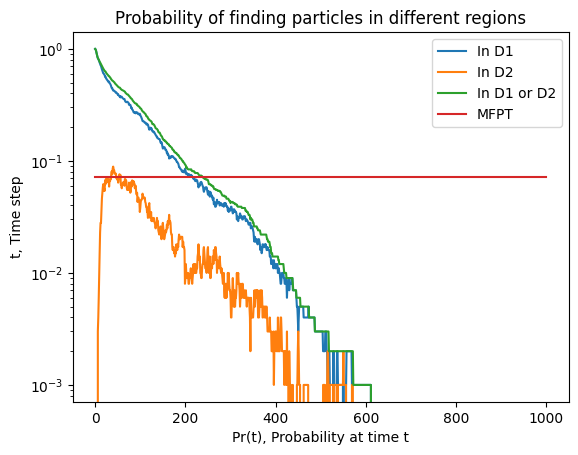

In [64]:
#Probability of finding a particle in medium1 or medium2 or hiting the target
count1 = np.zeros(nums)
count2 = np.zeros(nums)
count3 = np.zeros(nums)
for t in range(nums):
  for p in range(nump):
    count3[t] += np.count_nonzero((0 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R))
    count1[t] += np.count_nonzero((R < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R1))
    count2[t] += np.count_nonzero((R1 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R2))

xticks = np.linspace(1/nums, 1, nums)
yticks = np.linspace(1/nums, 1, nums)
plt.yscale("log")
plt.plot(count1/nump)
plt.plot(count2/nump)
plt.plot((count1 + count2)/nump)
plt.plot(np.tile(MFPT/nums, nums))
#plt.plot(count3/nump)
plt.legend(["In D1", "In D2", "In D1 or D2", "MFPT", "Hit target"])
plt.ylabel("t, Time step")
plt.xlabel("Pr(t), Probability at time t")
plt.title("Probability of finding particles in different regions")
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Prob_Strat_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

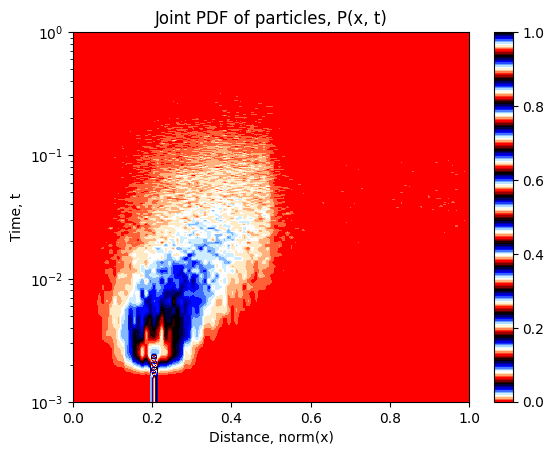

In [65]:
#Plot a heatmap of probability of particles
gridX = 100
gridT = nums
pos = np.round(np.linspace(0, 1, gridX + 1), 2)
tim = np.linspace(0, gridT, gridT+1)
PDF1D = np.zeros((gridT, gridX+1))

#Derive a heatmap of the particles
#Find the norm of particles at each time step
Z = np.linalg.norm(Y/R2, axis=0)

#Quantize it to 2 ( = log10(gridX)) decimal places as grix X is with such precision
Z = np.round(Z, 2)

for t in range(nums):
#position of all particles at time t
  for p in range(len(pos)):
    PDF1D[t][p] = np.count_nonzero(Z[t, :] == pos[p])

#Plot the heatmap of pdf
plt.title("Joint PDF of particles, P(x, t)")
#PDF1D is a 2D matrix with (0,0)th element on top left. Fip vertically
plt.yscale('log')
plt.imshow(np.flipud(PDF1D/nump), cmap = 'flag', extent = [0, 1, dt, dt*nums], aspect = "auto")
plt.xlabel("Distance, norm(x)")
plt.ylabel("Time, t")
plt.colorbar()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Heat_Strat_{nump}_{nums}_{D1}_{D2}.png')
#https://stackoverflow.com/questions/2546475/how-can-i-draw-a-log-normalized-imshow-plot-with-a-colorbar-representing-the-raw

# Simulate Isothermal Convention

In [66]:
#Hitting times if the target is hit
hittingTime = np.zeros(nump)
#Trajectory of a particle
X = np.zeros([dim, nums])
#Trajectories of all particles
Y = np.zeros([dim, nums, nump])


start_time = time.time()
for i in range(nump):
  #Initialize - The particle starts at a random positio outside the target
  if dim == 1:
    X[:, 0] = Init1D[i]
  elif dim == 2:
    X[:, 0] = Init2D[:, i]
  elif dim == 3:
    X[:, 0] = Init3D[:, i]

  #Find particle trajectories
  for j in range(1, nums):
    #Random increment in the position
    dRand = Eps[i, j, :]
    #Increment if particle is in medium1
    dX1 = dX1s[i, j, :]
    #Increment if particle is in medium2
    dX2 = dX2s[i, j, :]

    #Particle hits the target
    if R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) < R:
      X[:, j] = X[:, j - 1] + dX1
      X[:, j+1:] = -1
      hittingTime[i] = j
      break

    #Particle travels in medium1, without hitting the target
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and R < np.linalg.norm(X[:, j - 1] + dX1) < R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle is traveling in medium2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and R1 < np.linalg.norm(X[:, j - 1] + dX2) < R2:
      X[:, j] = X[:, j - 1] + dX2

    #Particle is reflected by the outer ball when its next step crosses the bound R2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) > R2:
      #Find the point of reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) + np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R2**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Image in D2
      X[:, j] = X[:, j - 1] + dX2 - 2*(1 - lamb)*np.dot(dX2, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

    #Particle diffuses from D1 to D2 with a one sided reflection coefficient
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) > R1:
      #Find the point of diffusion/reflection
      lamb = ( -np.dot(X[:, j - 1], dX1) + np.sqrt(np.dot(X[:, j - 1], dX1)**2 - (np.linalg.norm(dX1)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX1)**2)
      r0 = X[:, j - 1] + lamb*dX1
      if any(np.linalg.norm(r0 - poreCenters, axis=1) < r):
        #If particle's projection on surface of the inner ball is near any pore, diffuse to D2.
        if bernoulli.rvs(min(1, math.sqrt(D2/D1))):
          #Diffuse with time-splitting, if the random variable generated is 1
          #Residence times in each medium
          dt1 = (np.linalg.norm(lamb*dX1)/(np.linalg.norm(dRand)*np.sqrt(2*D1)))**2
          dt2 = ((1 - np.sqrt(dt1/dt))**2)*dt
          #Particle diffuses, increment by motion in D2
          X[:, j] = r0 + np.sqrt(2*D2*dt2)*dRand
        else:
          #Reflect, if the random variable generated is 0
          X[:, j] = X[:, j - 1] + dX1 - 2*(1-lamb)*np.dot(dX1, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)
      else:
          #Reflect particle is far from all pores
          X[:, j] = X[:, j - 1] + dX1 - 2*(1-lamb)*np.dot(dX1, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)

    #Particle diffuses from D2 to D1 with a one sided reflection coefficient
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) < R1:
      #Find the point of diffusion/reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) - np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      if any(np.linalg.norm(r0 - poreCenters, axis=1) < r):
        #If particle's projection on surface of the inner ball is near any pore, diffuse to D2.
        if bernoulli.rvs(min(1, math.sqrt(D1/D2))):
          #Diffuse with time-splitting, if the random variable generated is 1
          #Residence times in each medium
          dt2 = (np.linalg.norm(lamb*dX2)/(np.linalg.norm(dRand)*np.sqrt(2*D2)))**2
          dt1 = ((1 - np.sqrt(dt2/dt))**2)*dt
          #Particle diffuses, increment by motion in D1
          X[:, j] = r0 + np.sqrt(2*D1*dt1)*dRand
        else:
          #Reflect, if the random variable generated is 0
          X[:, j] = X[:, j - 1] + dX2 - 2*(1-lamb)*np.dot(dX2, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)
      else:
          #Reflect, if projection is far from all pores
          X[:, j] = X[:, j - 1] + dX2 - 2*(1-lamb)*np.dot(dX2, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)

  #Save the particle's trajectory
  Y[:, :, i] = X
  #print(i)

#Time taken to simulate motion of nump particles each taking nums steps
print("nump = ", nump, "nums = ", nums, "--- %s seconds ---" % (time.time() - start_time))

nump =  1000 nums =  1000 --- 11.101495742797852 seconds ---


# Plots

Mean First Passage Time =  72.0046565774156


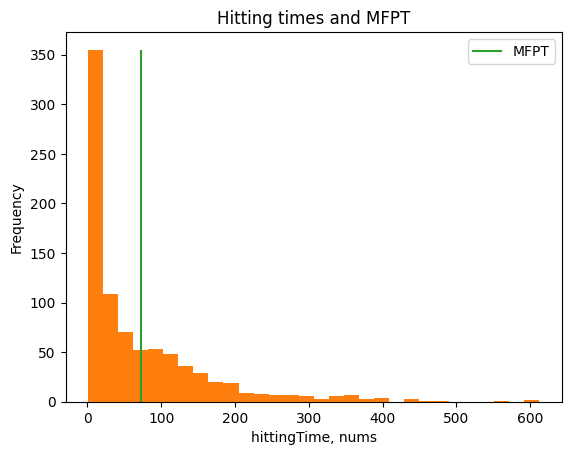

In [67]:
#Histogram hitting times and plot MFPT
hit = hittingTime[hittingTime != 0]
#Should zero be removed for MFPT calculation?
MFPT = np.average(hit)
print("Mean First Passage Time = ", MFPT)
plt.plot(np.tile(MFPT, int(max(plt.hist(hit, 30)[0]))), range(int(max(plt.hist(hit, 30)[0]))), label="MFPT")
#plt.hist(hit, 30, label="Zero removed")
#plt.hist(hittingTime, 30, label="Zero inflated")
plt.ylabel("Frequency")
plt.xlabel("hittingTime, nums")
plt.title("Hitting times and MFPT")
plt.legend()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Hist_Iso_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

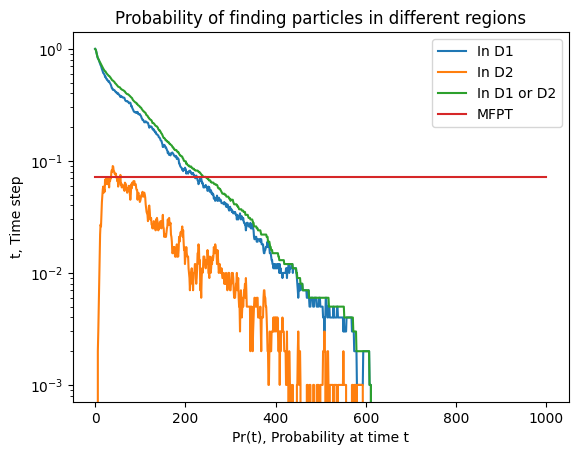

In [68]:
#Probability of finding a particle in medium1 or medium2 or hiting the target
count1 = np.zeros(nums)
count2 = np.zeros(nums)
count3 = np.zeros(nums)
for t in range(nums):
  for p in range(nump):
    count3[t] += np.count_nonzero((0 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R))
    count1[t] += np.count_nonzero((R < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R1))
    count2[t] += np.count_nonzero((R1 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R2))

xticks = np.linspace(1/nums, 1, nums)
yticks = np.linspace(1/nums, 1, nums)
plt.yscale("log")
plt.plot(count1/nump)
plt.plot(count2/nump)
plt.plot((count1 + count2)/nump)
plt.plot(np.tile(MFPT/nums, nums))
#plt.plot(count3/nump)
plt.legend(["In D1", "In D2", "In D1 or D2", "MFPT", "Hit target"])
plt.ylabel("t, Time step")
plt.xlabel("Pr(t), Probability at time t")
plt.title("Probability of finding particles in different regions")
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Prob_Iso_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

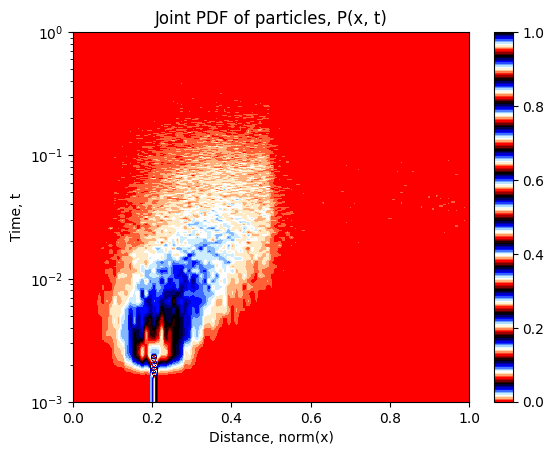

In [69]:
#Plot a heatmap of probability of particles
gridX = 100
gridT = nums
pos = np.round(np.linspace(0, 1, gridX + 1), 2)
tim = np.linspace(0, gridT, gridT+1)
PDF1D = np.zeros((gridT, gridX+1))

#Derive a heatmap of the particles
#Find the norm of particles at each time step
Z = np.linalg.norm(Y/R2, axis=0)

#Quantize it to 2 ( = log10(gridX)) decimal places as grix X is with such precision
Z = np.round(Z, 2)

for t in range(nums):
#position of all particles at time t
  for p in range(len(pos)):
    PDF1D[t][p] = np.count_nonzero(Z[t, :] == pos[p])

#Plot the heatmap of pdf
plt.title("Joint PDF of particles, P(x, t)")
#PDF1D is a 2D matrix with (0,0)th element on top left. Fip vertically
plt.yscale('log')
plt.imshow(np.flipud(PDF1D/nump), cmap = 'flag', extent = [0, 1, dt, dt*nums], aspect = "auto")
plt.xlabel("Distance, norm(x)")
plt.ylabel("Time, t")
plt.colorbar()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Heat_Ito_{nump}_{nums}_{D1}_{D2}.png')

# D1 = 10, D2 = 1

#Simulate Ito Convention

In [70]:
#Diffusivity of inner medium
D1 = 10
#Diffusivity of outer medium
D2 = 1

#Hitting times if the target is hit
hittingTime = np.zeros(nump)
#Trajectory of a particle
X = np.zeros([dim, nums])
#Trajectories of all particles
Y = np.zeros([dim, nums, nump])

In [71]:
start_time = time.time()
for i in range(nump):
  #Initialize - The particle starts at a random position outside the target
  if dim == 1:
    X[:, 0] = Init1D[i]
  if dim == 2:
    X[:, 0] = Init2D[:, i]
  elif dim == 3:
    X[:, 0] = Init3D[:, i]

  #Find particle trajectories
  for j in range(1, nums):
    #Random increment in the position
    dRand = Eps[i, j, :]
    #Increment if particle is in medium1
    dX1 = dX1s[i, j, :]
    #Increment if particle is in medium2
    dX2 = dX2s[i, j, :]

    #Particle hits the target
    if R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) < R:
      X[:, j] = X[:, j - 1] + dX1
      #For plotting
      hittingTime[i] = j
      """TODO - How to remove the particle once it hits the target?"""
      X[:, j+1:] = -1
      #print(j, "Hit", X[:, j], np.linalg.norm(X[:, j]), np.linalg.norm(X[:, j] - X[:, j-1]))
      break

    #Particle is traveling in medium1 outside the target
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and R < np.linalg.norm(X[:, j - 1] + dX1) < R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle is traveling in medium2, without hitting the reflecting boundary
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and R1 < np.linalg.norm(X[:, j - 1] + dX2) < R2:
      X[:, j] = X[:, j - 1] + dX2

    #Particle is reflected by the outer ball when its next step crosses the bound R2 - Reflect in D2
    #https://math.stackexchange.com/questions/13261/how-to-get-a-reflection-vector
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) > R2:
      #Find the point of reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) + np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R2**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Image in D2
      X[:, j] = X[:, j - 1] + dX2 - 2*(1-lamb)*np.dot(dX2, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)

    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) > R1:
      #Find the point of reflection/diffusion
      lamb = ( -np.dot(X[:, j - 1], dX1) + np.sqrt(np.dot(X[:, j - 1], dX1)**2 - (np.linalg.norm(dX1)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX1)**2)
      r0 = X[:, j - 1] + lamb*dX1
      if any(np.linalg.norm(r0 - poreCenters, axis=1) < r):
        #If particle's projection on surface of the inner ball is near any pore, diffuse to D2.
        X[:, j] = X[:, j - 1] + dX1
      else:
        #Particle is reflected by inner ball when it's near the media boundary and far from all the pores
        #Image in D1
        X[:, j] = X[:, j - 1] + dX1 - 2*(1-lamb)*np.dot(dX1, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)
        #print(j, "Reflection in D1", X[:, j], np.linalg.norm(X[:, j]), np.linalg.norm(X[:, j] - X[:, j-1]))

    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) < R1:
      #Find the point of reflection/diffusion
      lamb = ( -np.dot(X[:, j - 1], dX2) - np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #If particle projected on surface of ball 1 is near a pore, diffuse to D1. Else reflect it
      if any(np.linalg.norm(r0 - poreCenters, axis=1) < r):
        #Diffuse to D1 via a pore
        X[:, j] = X[:, j - 1] + dX1
      else:
        #Reflect - Image in D2
        X[:, j] = X[:, j - 1] + dX2 - 2*(1-lamb)*np.dot(dX2, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)
        #print(j, "Reflection in D2", X[:, j], np.linalg.norm(X[:, j]), np.linalg.norm(X[:, j] - X[:, j-1]))
  #Save the particle's trajectory
  Y[:, :, i] = X
  #print(i)

#Time taken to simulate motion of nump particles each taking nums steps
print("nump = ", nump, "nums = ", nums, "--- %s seconds ---" % (time.time() - start_time))

nump =  1000 nums =  1000 --- 13.656282424926758 seconds ---


# Plots

Mean First Passage Time =  63.605228758169936


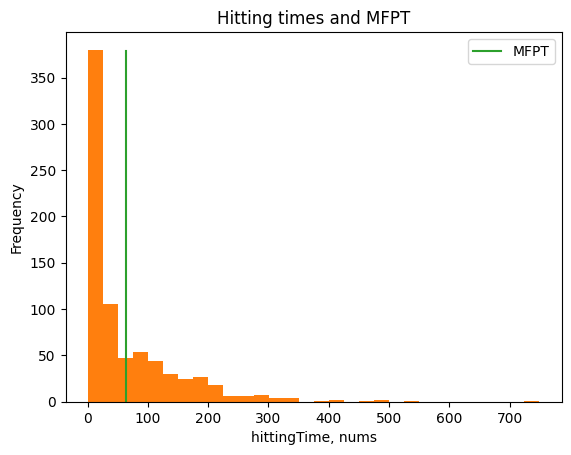

In [72]:
#Histogram hitting times and plot MFPT
hit = hittingTime[hittingTime != 0]
#Should zero be removed for MFPT calculation?
MFPT = np.average(hit)
print("Mean First Passage Time = ", MFPT)
plt.plot(np.tile(MFPT, int(max(plt.hist(hit, 30)[0]))), range(int(max(plt.hist(hit, 30)[0]))), label="MFPT")
#plt.hist(hit, 30, label="Zero removed")
#plt.hist(hittingTime, 30, label="Zero inflated")
plt.ylabel("Frequency")
plt.xlabel("hittingTime, nums")
plt.title("Hitting times and MFPT")
plt.legend()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Hist_Ito_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

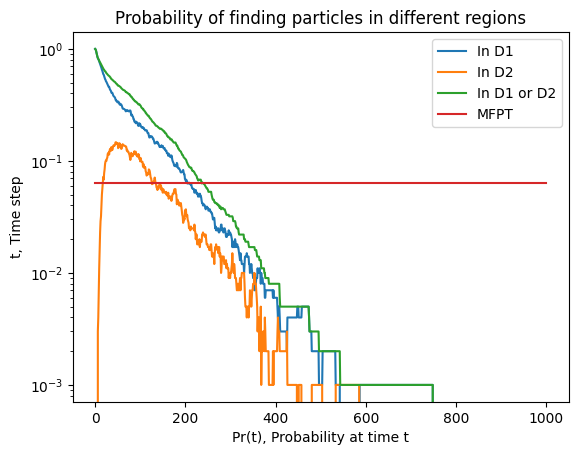

In [73]:
#Probability of finding a particle in medium1 or medium2 or hiting the target
count1 = np.zeros(nums)
count2 = np.zeros(nums)
count3 = np.zeros(nums)
for t in range(nums):
  for p in range(nump):
    count3[t] += np.count_nonzero((0 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R))
    count1[t] += np.count_nonzero((R < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R1))
    count2[t] += np.count_nonzero((R1 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R2))

xticks = np.linspace(1/nums, 1, nums)
yticks = np.linspace(1/nums, 1, nums)
plt.yscale("log")
plt.plot(count1/nump)
plt.plot(count2/nump)
plt.plot((count1 + count2)/nump)
plt.plot(np.tile(MFPT/nums, nums))
#plt.plot(count3/nump)
plt.legend(["In D1", "In D2", "In D1 or D2", "MFPT", "Hit target"])
plt.ylabel("t, Time step")
plt.xlabel("Pr(t), Probability at time t")
plt.title("Probability of finding particles in different regions")
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Prob_Ito_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

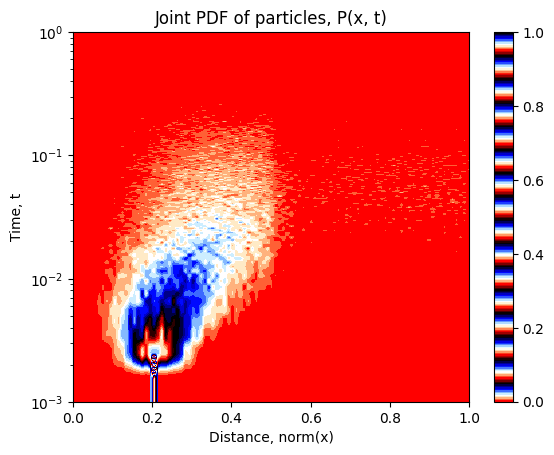

In [74]:
#Plot a heatmap of probability of particles
gridX = 100
gridT = nums
pos = np.round(np.linspace(0, 1, gridX + 1), 2)
tim = np.linspace(0, gridT, gridT+1)
PDF1D = np.zeros((gridT, gridX+1))

#Derive a heatmap of the particles
#Find the norm of particles at each time step
Z = np.linalg.norm(Y/R2, axis=0)

#Quantize it to 2 ( = log10(gridX)) decimal places as grix X is with such precision
Z = np.round(Z, 2)

for t in range(nums):
#position of all particles at time t
  for p in range(len(pos)):
    PDF1D[t][p] = np.count_nonzero(Z[t, :] == pos[p])

#Plot the heatmap of pdf
plt.title("Joint PDF of particles, P(x, t)")
#PDF1D is a 2D matrix with (0,0)th element on top left. Fip vertically
plt.yscale('log')
plt.imshow(np.flipud(PDF1D/nump), cmap = 'flag', extent = [0, 1, dt, dt*nums], aspect = "auto")
plt.xlabel("Distance, norm(x)")
plt.ylabel("Time, t")
plt.colorbar()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Heat_Ito_{nump}_{nums}_{D1}_{D2}.png')

#Simulate Stratonovich Convention

In [75]:
#Hitting times if the target is hit
hittingTime = np.zeros(nump)
#Trajectory of a particle
X = np.zeros([dim, nums])
#Trajectories of all particles
Y = np.zeros([dim, nums, nump])


start_time = time.time()
for i in range(nump):
  #Initialize - The particle starts at a random positio outside the target
  if dim == 1:
    X[:, 0] = Init1D[i]
  elif dim == 2:
    X[:, 0] = Init2D[:, i]
  elif dim == 3:
    X[:, 0] = Init3D[:, i]

  #Find particle trajectories
  for j in range(1, nums):
    #Random increment in the position
    dRand = Eps[i, j, :]
    #Increment if particle is in medium1
    dX1 = dX1s[i, j, :]
    #Increment if particle is in medium2
    dX2 = dX2s[i, j, :]

    #Particle travels in medium1, without hitting the target
    if R < np.linalg.norm(X[:, j - 1]) < R1 and R < np.linalg.norm(X[:, j - 1] + dX1) < R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle is traveling in medium2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and R1 < np.linalg.norm(X[:, j - 1] + dX2) < R2:
      X[:, j] = X[:, j - 1] + dX2

    #Particle is reflected by the outer ball when its next step crosses the bound R2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) > R2:
      #Find the point of reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) + np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R2**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Image in D2
      X[:, j] = X[:, j - 1] + dX2 - 2*(1 - lamb)*np.dot(dX2, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) > R1:
      #Find the point of reflection/diffusion
      lamb = ( -np.dot(X[:, j - 1], dX1) + np.sqrt(np.dot(X[:, j - 1], dX1)**2 - (np.linalg.norm(dX1)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX1)**2)
      r0 = X[:, j - 1] + lamb*dX1
      if any(np.linalg.norm(r0 - poreCenters, axis=1) < r):
        #If particle's projection on surface of the inner ball is near any pore, diffuse to D2.
        #Residence times in each medium
        dt1 = (np.linalg.norm(lamb*dX1)/(np.linalg.norm(dRand)*np.sqrt(2*D1)))**2
        dt2 = ((1 - np.sqrt(dt1/dt))**2)*dt
        #Particle diffuses, increment by motion in D2
        X[:, j] = r0 + np.sqrt(2*D2*dt2)*dRand
        #print(j, "Diffusion from D1 to D2", dt1, dt2, dt, X[:, j], np.linalg.norm(X[:, j]), np.linalg.norm(X[:, j] - X[:, j-1]))
        #print(X[:, j-1])
        #print(X[:, j])
      else:
        #Particle is reflected by inner ball when it's near the media boundary and far from all the pores
        #Image in D1
        X[:, j] = X[:, j - 1] + dX1 - 2*(1-lamb)*np.dot(dX1, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)
        #print(j, "Reflection in D1", X[:, j], np.linalg.norm(X[:, j]), np.linalg.norm(X[:, j] - X[:, j-1]))

    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) < R1:
      #Find the point of reflection/diffusion
      lamb = ( -np.dot(X[:, j - 1], dX2) - np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #If particle projected on surface of ball 1 is near a pore, diffuse to D1. Else reflect it
      if any(np.linalg.norm(r0 - poreCenters, axis=1) < r):
        #Residence times in each medium
        dt2 = (np.linalg.norm(lamb*dX2)/(np.linalg.norm(dRand)*np.sqrt(2*D2)))**2
        dt1 = ((1 - np.sqrt(dt2/dt))**2)*dt
        #Particle diffuses, increment by motion in D1
        X[:, j] = r0 + np.sqrt(2*D1*dt1)*dRand
        #print(j, "Diffusion from D2 to D1", dt1, dt2, dt, X[:, j], np.linalg.norm(X[:, j]), np.linalg.norm(X[:, j] - X[:, j-1]))
      else:
        #Image in D2
        X[:, j] = X[:, j - 1] + dX2 - 2*(1-lamb)*np.dot(dX2, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)
        #print(j, "Reflection in D2", X[:, j], np.linalg.norm(X[:, j]), np.linalg.norm(X[:, j] - X[:, j-1]))

    #Particle hits the target
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) < R:
      X[:, j] = X[:, j - 1] + dX1
      X[:, j+1:] = -1
      hittingTime[i] = j
      break

  #Save the particle's trajectory
  Y[:, :, i] = X
  #print(i)

#Time taken to simulate motion of nump particles each taking nums steps
print("nump = ", nump, "nums = ", nums, "--- %s seconds ---" % (time.time() - start_time))

nump =  1000 nums =  1000 --- 10.302464246749878 seconds ---


# Plots

Mean First Passage Time =  61.460701330108826


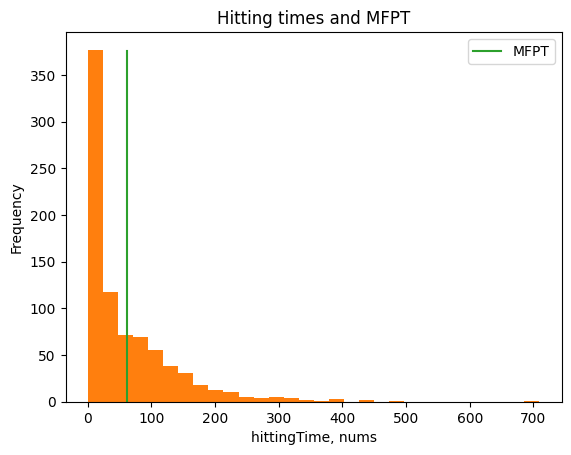

In [76]:
#Histogram hitting times and plot MFPT
hit = hittingTime[hittingTime != 0]
#Should zero be removed for MFPT calculation?
MFPT = np.average(hit)
print("Mean First Passage Time = ", MFPT)
plt.plot(np.tile(MFPT, int(max(plt.hist(hit, 30)[0]))), range(int(max(plt.hist(hit, 30)[0]))), label="MFPT")
#plt.hist(hit, 30, label="Zero removed")
#plt.hist(hittingTime, 30, label="Zero inflated")
plt.ylabel("Frequency")
plt.xlabel("hittingTime, nums")
plt.title("Hitting times and MFPT")
plt.legend()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Hist_Strat_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

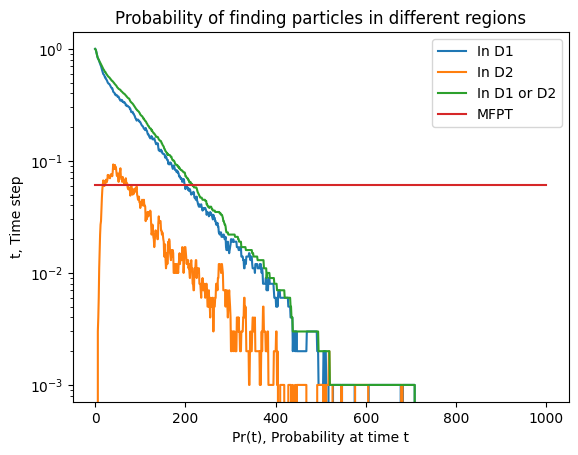

In [77]:
#Probability of finding a particle in medium1 or medium2 or hiting the target
count1 = np.zeros(nums)
count2 = np.zeros(nums)
count3 = np.zeros(nums)
for t in range(nums):
  for p in range(nump):
    count3[t] += np.count_nonzero((0 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R))
    count1[t] += np.count_nonzero((R < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R1))
    count2[t] += np.count_nonzero((R1 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R2))

xticks = np.linspace(1/nums, 1, nums)
yticks = np.linspace(1/nums, 1, nums)
plt.yscale("log")
plt.plot(count1/nump)
plt.plot(count2/nump)
plt.plot((count1 + count2)/nump)
plt.plot(np.tile(MFPT/nums, nums))
#plt.plot(count3/nump)
plt.legend(["In D1", "In D2", "In D1 or D2", "MFPT", "Hit target"])
plt.ylabel("t, Time step")
plt.xlabel("Pr(t), Probability at time t")
plt.title("Probability of finding particles in different regions")
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Prob_Strat_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

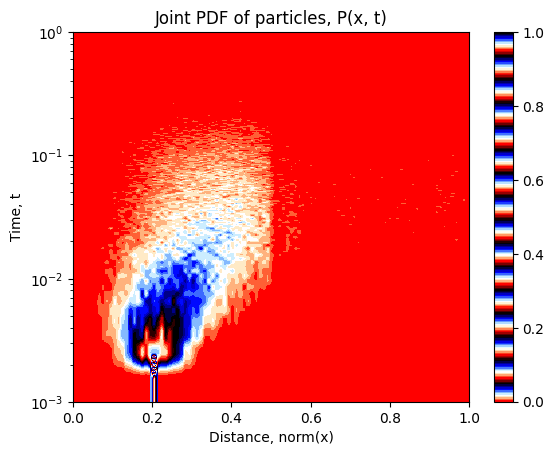

In [78]:
#Plot a heatmap of probability of particles
gridX = 100
gridT = nums
pos = np.round(np.linspace(0, 1, gridX + 1), 2)
tim = np.linspace(0, gridT, gridT+1)
PDF1D = np.zeros((gridT, gridX+1))

#Derive a heatmap of the particles
#Find the norm of particles at each time step
Z = np.linalg.norm(Y/R2, axis=0)

#Quantize it to 2 ( = log10(gridX)) decimal places as grix X is with such precision
Z = np.round(Z, 2)

for t in range(nums):
#position of all particles at time t
  for p in range(len(pos)):
    PDF1D[t][p] = np.count_nonzero(Z[t, :] == pos[p])

#Plot the heatmap of pdf
plt.title("Joint PDF of particles, P(x, t)")
#PDF1D is a 2D matrix with (0,0)th element on top left. Fip vertically
plt.yscale('log')
plt.imshow(np.flipud(PDF1D/nump), cmap = 'flag', extent = [0, 1, dt, dt*nums], aspect = "auto")
plt.xlabel("Distance, norm(x)")
plt.ylabel("Time, t")
plt.colorbar()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Heat_Strat_{nump}_{nums}_{D1}_{D2}.png')
#https://stackoverflow.com/questions/2546475/how-can-i-draw-a-log-normalized-imshow-plot-with-a-colorbar-representing-the-raw

# Simulate Isothermal Convention

In [79]:
#Hitting times if the target is hit
hittingTime = np.zeros(nump)
#Trajectory of a particle
X = np.zeros([dim, nums])
#Trajectories of all particles
Y = np.zeros([dim, nums, nump])


start_time = time.time()
for i in range(nump):
  #Initialize - The particle starts at a random positio outside the target
  if dim == 1:
    X[:, 0] = Init1D[i]
  elif dim == 2:
    X[:, 0] = Init2D[:, i]
  elif dim == 3:
    X[:, 0] = Init3D[:, i]

  #Find particle trajectories
  for j in range(1, nums):
    #Random increment in the position
    dRand = Eps[i, j, :]
    #Increment if particle is in medium1
    dX1 = dX1s[i, j, :]
    #Increment if particle is in medium2
    dX2 = dX2s[i, j, :]

    #Particle hits the target
    if R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) < R:
      X[:, j] = X[:, j - 1] + dX1
      X[:, j+1:] = -1
      hittingTime[i] = j
      break

    #Particle travels in medium1, without hitting the target
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and R < np.linalg.norm(X[:, j - 1] + dX1) < R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle is traveling in medium2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and R1 < np.linalg.norm(X[:, j - 1] + dX2) < R2:
      X[:, j] = X[:, j - 1] + dX2

    #Particle is reflected by the outer ball when its next step crosses the bound R2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) > R2:
      #Find the point of reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) + np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R2**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Image in D2
      X[:, j] = X[:, j - 1] + dX2 - 2*(1 - lamb)*np.dot(dX2, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

    #Particle diffuses from D1 to D2 with a one sided reflection coefficient
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) > R1:
      #Find the point of diffusion/reflection
      lamb = ( -np.dot(X[:, j - 1], dX1) + np.sqrt(np.dot(X[:, j - 1], dX1)**2 - (np.linalg.norm(dX1)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX1)**2)
      r0 = X[:, j - 1] + lamb*dX1
      if any(np.linalg.norm(r0 - poreCenters, axis=1) < r):
        #If particle's projection on surface of the inner ball is near any pore, diffuse to D2.
        if bernoulli.rvs(min(1, math.sqrt(D2/D1))):
          #Diffuse with time-splitting, if the random variable generated is 1
          #Residence times in each medium
          dt1 = (np.linalg.norm(lamb*dX1)/(np.linalg.norm(dRand)*np.sqrt(2*D1)))**2
          dt2 = ((1 - np.sqrt(dt1/dt))**2)*dt
          #Particle diffuses, increment by motion in D2
          X[:, j] = r0 + np.sqrt(2*D2*dt2)*dRand
        else:
          #Reflect, if the random variable generated is 0
          X[:, j] = X[:, j - 1] + dX1 - 2*(1-lamb)*np.dot(dX1, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)
      else:
          #Reflect particle is far from all pores
          X[:, j] = X[:, j - 1] + dX1 - 2*(1-lamb)*np.dot(dX1, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)

    #Particle diffuses from D2 to D1 with a one sided reflection coefficient
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) < R1:
      #Find the point of diffusion/reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) - np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      if any(np.linalg.norm(r0 - poreCenters, axis=1) < r):
        #If particle's projection on surface of the inner ball is near any pore, diffuse to D2.
        if bernoulli.rvs(min(1, math.sqrt(D1/D2))):
          #Diffuse with time-splitting, if the random variable generated is 1
          #Residence times in each medium
          dt2 = (np.linalg.norm(lamb*dX2)/(np.linalg.norm(dRand)*np.sqrt(2*D2)))**2
          dt1 = ((1 - np.sqrt(dt2/dt))**2)*dt
          #Particle diffuses, increment by motion in D1
          X[:, j] = r0 + np.sqrt(2*D1*dt1)*dRand
        else:
          #Reflect, if the random variable generated is 0
          X[:, j] = X[:, j - 1] + dX2 - 2*(1-lamb)*np.dot(dX2, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)
      else:
          #Reflect, if projection is far from all pores
          X[:, j] = X[:, j - 1] + dX2 - 2*(1-lamb)*np.dot(dX2, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)

  #Save the particle's trajectory
  Y[:, :, i] = X
  #print(i)

#Time taken to simulate motion of nump particles each taking nums steps
print("nump = ", nump, "nums = ", nums, "--- %s seconds ---" % (time.time() - start_time))

nump =  1000 nums =  1000 --- 8.392472505569458 seconds ---


# Plots

Mean First Passage Time =  85.10758776896942


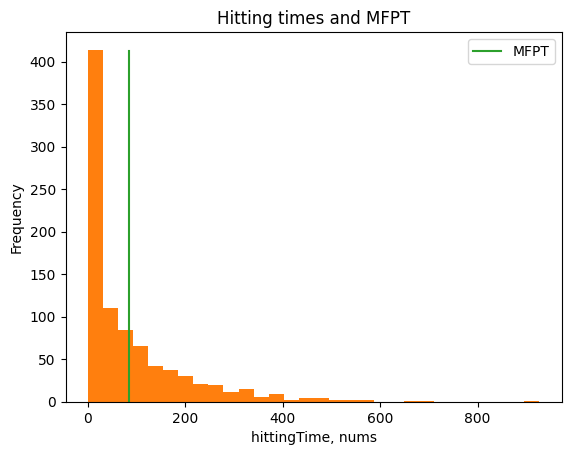

In [80]:
#Histogram hitting times and plot MFPT
hit = hittingTime[hittingTime != 0]
#Should zero be removed for MFPT calculation?
MFPT = np.average(hit)
print("Mean First Passage Time = ", MFPT)
plt.plot(np.tile(MFPT, int(max(plt.hist(hit, 30)[0]))), range(int(max(plt.hist(hit, 30)[0]))), label="MFPT")
#plt.hist(hit, 30, label="Zero removed")
#plt.hist(hittingTime, 30, label="Zero inflated")
plt.ylabel("Frequency")
plt.xlabel("hittingTime, nums")
plt.title("Hitting times and MFPT")
plt.legend()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Hist_Iso_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

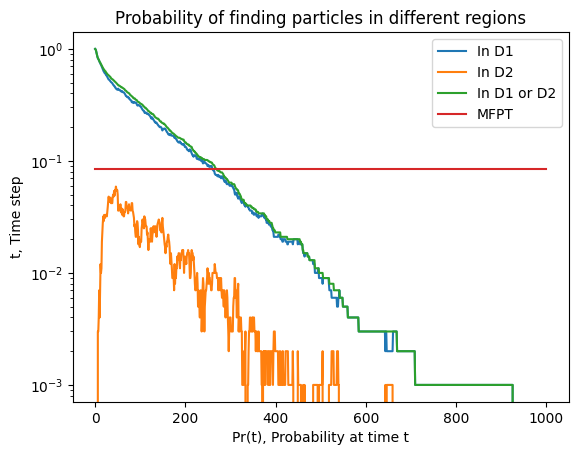

In [81]:
#Probability of finding a particle in medium1 or medium2 or hiting the target
count1 = np.zeros(nums)
count2 = np.zeros(nums)
count3 = np.zeros(nums)
for t in range(nums):
  for p in range(nump):
    count3[t] += np.count_nonzero((0 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R))
    count1[t] += np.count_nonzero((R < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R1))
    count2[t] += np.count_nonzero((R1 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R2))

xticks = np.linspace(1/nums, 1, nums)
yticks = np.linspace(1/nums, 1, nums)
plt.yscale("log")
plt.plot(count1/nump)
plt.plot(count2/nump)
plt.plot((count1 + count2)/nump)
plt.plot(np.tile(MFPT/nums, nums))
#plt.plot(count3/nump)
plt.legend(["In D1", "In D2", "In D1 or D2", "MFPT", "Hit target"])
plt.ylabel("t, Time step")
plt.xlabel("Pr(t), Probability at time t")
plt.title("Probability of finding particles in different regions")
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Prob_Iso_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

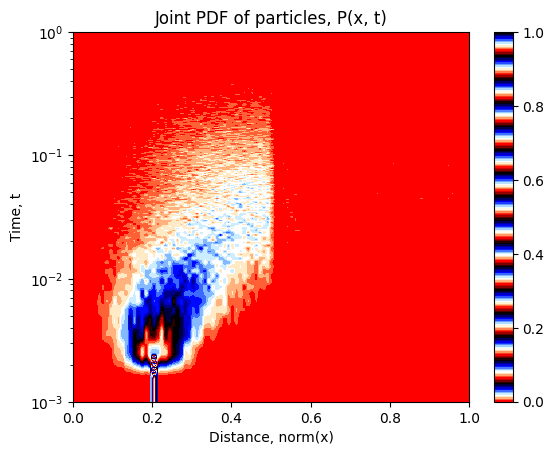

In [82]:
#Plot a heatmap of probability of particles
gridX = 100
gridT = nums
pos = np.round(np.linspace(0, 1, gridX + 1), 2)
tim = np.linspace(0, gridT, gridT+1)
PDF1D = np.zeros((gridT, gridX+1))

#Derive a heatmap of the particles
#Find the norm of particles at each time step
Z = np.linalg.norm(Y/R2, axis=0)

#Quantize it to 2 ( = log10(gridX)) decimal places as grix X is with such precision
Z = np.round(Z, 2)

for t in range(nums):
#position of all particles at time t
  for p in range(len(pos)):
    PDF1D[t][p] = np.count_nonzero(Z[t, :] == pos[p])

#Plot the heatmap of pdf
plt.title("Joint PDF of particles, P(x, t)")
#PDF1D is a 2D matrix with (0,0)th element on top left. Fip vertically
plt.yscale('log')
plt.imshow(np.flipud(PDF1D/nump), cmap = 'flag', extent = [0, 1, dt, dt*nums], aspect = "auto")
plt.xlabel("Distance, norm(x)")
plt.ylabel("Time, t")
plt.colorbar()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Heat_Ito_{nump}_{nums}_{D1}_{D2}.png')

# D1 = 100, D2 = 1

#Simulate Ito Convention

In [83]:
#Diffusivity of inner medium
D1 = 1
#Diffusivity of outer medium
D2 = 1.1

#Hitting times if the target is hit
hittingTime = np.zeros(nump)
#Trajectory of a particle
X = np.zeros([dim, nums])
#Trajectories of all particles
Y = np.zeros([dim, nums, nump])

In [84]:
start_time = time.time()
for i in range(nump):
  #Initialize - The particle starts at a random position outside the target
  if dim == 1:
    X[:, 0] = Init1D[i]
  if dim == 2:
    X[:, 0] = Init2D[:, i]
  elif dim == 3:
    X[:, 0] = Init3D[:, i]

  #Find particle trajectories
  for j in range(1, nums):
    #Random increment in the position
    dRand = Eps[i, j, :]
    #Increment if particle is in medium1
    dX1 = dX1s[i, j, :]
    #Increment if particle is in medium2
    dX2 = dX2s[i, j, :]

    #Particle hits the target
    if R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) < R:
      X[:, j] = X[:, j - 1] + dX1
      #For plotting
      hittingTime[i] = j
      """TODO - How to remove the particle once it hits the target?"""
      X[:, j+1:] = -1
      #print(j, "Hit", X[:, j], np.linalg.norm(X[:, j]), np.linalg.norm(X[:, j] - X[:, j-1]))
      break

    #Particle is traveling in medium1 outside the target
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and R < np.linalg.norm(X[:, j - 1] + dX1) < R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle is traveling in medium2, without hitting the reflecting boundary
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and R1 < np.linalg.norm(X[:, j - 1] + dX2) < R2:
      X[:, j] = X[:, j - 1] + dX2

    #Particle is reflected by the outer ball when its next step crosses the bound R2 - Reflect in D2
    #https://math.stackexchange.com/questions/13261/how-to-get-a-reflection-vector
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) > R2:
      #Find the point of reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) + np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R2**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Image in D2
      X[:, j] = X[:, j - 1] + dX2 - 2*(1-lamb)*np.dot(dX2, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)

    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) > R1:
      #Find the point of reflection/diffusion
      lamb = ( -np.dot(X[:, j - 1], dX1) + np.sqrt(np.dot(X[:, j - 1], dX1)**2 - (np.linalg.norm(dX1)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX1)**2)
      r0 = X[:, j - 1] + lamb*dX1
      if any(np.linalg.norm(r0 - poreCenters, axis=1) < r):
        #If particle's projection on surface of the inner ball is near any pore, diffuse to D2.
        X[:, j] = X[:, j - 1] + dX1
      else:
        #Particle is reflected by inner ball when it's near the media boundary and far from all the pores
        #Image in D1
        X[:, j] = X[:, j - 1] + dX1 - 2*(1-lamb)*np.dot(dX1, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)
        #print(j, "Reflection in D1", X[:, j], np.linalg.norm(X[:, j]), np.linalg.norm(X[:, j] - X[:, j-1]))

    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) < R1:
      #Find the point of reflection/diffusion
      lamb = ( -np.dot(X[:, j - 1], dX2) - np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #If particle projected on surface of ball 1 is near a pore, diffuse to D1. Else reflect it
      if any(np.linalg.norm(r0 - poreCenters, axis=1) < r):
        #Diffuse to D1 via a pore
        X[:, j] = X[:, j - 1] + dX1
      else:
        #Reflect - Image in D2
        X[:, j] = X[:, j - 1] + dX2 - 2*(1-lamb)*np.dot(dX2, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)
        #print(j, "Reflection in D2", X[:, j], np.linalg.norm(X[:, j]), np.linalg.norm(X[:, j] - X[:, j-1]))
  #Save the particle's trajectory
  Y[:, :, i] = X
  #print(i)

#Time taken to simulate motion of nump particles each taking nums steps
print("nump = ", nump, "nums = ", nums, "--- %s seconds ---" % (time.time() - start_time))

nump =  1000 nums =  1000 --- 13.970972776412964 seconds ---


# Plots

Mean First Passage Time =  63.605228758169936


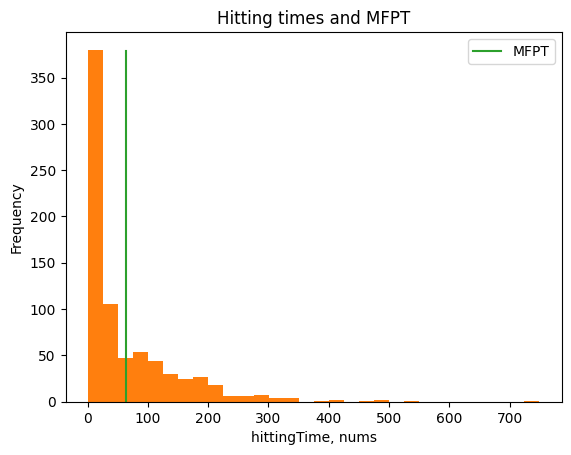

In [85]:
#Histogram hitting times and plot MFPT
hit = hittingTime[hittingTime != 0]
#Should zero be removed for MFPT calculation?
MFPT = np.average(hit)
print("Mean First Passage Time = ", MFPT)
plt.plot(np.tile(MFPT, int(max(plt.hist(hit, 30)[0]))), range(int(max(plt.hist(hit, 30)[0]))), label="MFPT")
#plt.hist(hit, 30, label="Zero removed")
#plt.hist(hittingTime, 30, label="Zero inflated")
plt.ylabel("Frequency")
plt.xlabel("hittingTime, nums")
plt.title("Hitting times and MFPT")
plt.legend()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Hist_Ito_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

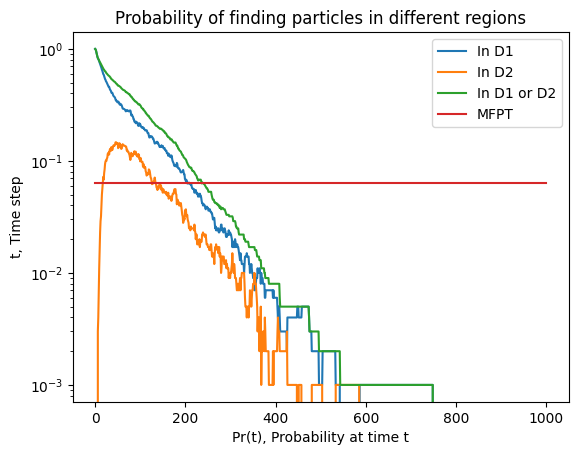

In [86]:
#Probability of finding a particle in medium1 or medium2 or hiting the target
count1 = np.zeros(nums)
count2 = np.zeros(nums)
count3 = np.zeros(nums)
for t in range(nums):
  for p in range(nump):
    count3[t] += np.count_nonzero((0 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R))
    count1[t] += np.count_nonzero((R < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R1))
    count2[t] += np.count_nonzero((R1 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R2))

xticks = np.linspace(1/nums, 1, nums)
yticks = np.linspace(1/nums, 1, nums)
plt.yscale("log")
plt.plot(count1/nump)
plt.plot(count2/nump)
plt.plot((count1 + count2)/nump)
plt.plot(np.tile(MFPT/nums, nums))
#plt.plot(count3/nump)
plt.legend(["In D1", "In D2", "In D1 or D2", "MFPT", "Hit target"])
plt.ylabel("t, Time step")
plt.xlabel("Pr(t), Probability at time t")
plt.title("Probability of finding particles in different regions")
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Prob_Ito_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

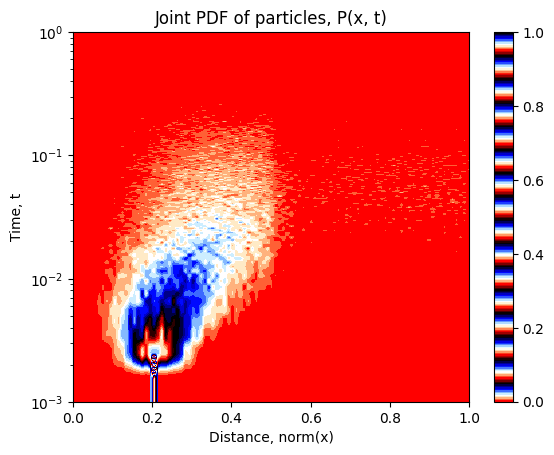

In [87]:
#Plot a heatmap of probability of particles
gridX = 100
gridT = nums
pos = np.round(np.linspace(0, 1, gridX + 1), 2)
tim = np.linspace(0, gridT, gridT+1)
PDF1D = np.zeros((gridT, gridX+1))

#Derive a heatmap of the particles
#Find the norm of particles at each time step
Z = np.linalg.norm(Y/R2, axis=0)

#Quantize it to 2 ( = log10(gridX)) decimal places as grix X is with such precision
Z = np.round(Z, 2)

for t in range(nums):
#position of all particles at time t
  for p in range(len(pos)):
    PDF1D[t][p] = np.count_nonzero(Z[t, :] == pos[p])

#Plot the heatmap of pdf
plt.title("Joint PDF of particles, P(x, t)")
#PDF1D is a 2D matrix with (0,0)th element on top left. Fip vertically
plt.yscale('log')
plt.imshow(np.flipud(PDF1D/nump), cmap = 'flag', extent = [0, 1, dt, dt*nums], aspect = "auto")
plt.xlabel("Distance, norm(x)")
plt.ylabel("Time, t")
plt.colorbar()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Heat_Ito_{nump}_{nums}_{D1}_{D2}.png')

#Simulate Stratonovich Convention

In [88]:
#Hitting times if the target is hit
hittingTime = np.zeros(nump)
#Trajectory of a particle
X = np.zeros([dim, nums])
#Trajectories of all particles
Y = np.zeros([dim, nums, nump])


start_time = time.time()
for i in range(nump):
  #Initialize - The particle starts at a random positio outside the target
  if dim == 1:
    X[:, 0] = Init1D[i]
  elif dim == 2:
    X[:, 0] = Init2D[:, i]
  elif dim == 3:
    X[:, 0] = Init3D[:, i]

  #Find particle trajectories
  for j in range(1, nums):
    #Random increment in the position
    dRand = Eps[i, j, :]
    #Increment if particle is in medium1
    dX1 = dX1s[i, j, :]
    #Increment if particle is in medium2
    dX2 = dX2s[i, j, :]

    #Particle travels in medium1, without hitting the target
    if R < np.linalg.norm(X[:, j - 1]) < R1 and R < np.linalg.norm(X[:, j - 1] + dX1) < R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle is traveling in medium2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and R1 < np.linalg.norm(X[:, j - 1] + dX2) < R2:
      X[:, j] = X[:, j - 1] + dX2

    #Particle is reflected by the outer ball when its next step crosses the bound R2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) > R2:
      #Find the point of reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) + np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R2**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Image in D2
      X[:, j] = X[:, j - 1] + dX2 - 2*(1 - lamb)*np.dot(dX2, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) > R1:
      #Find the point of reflection/diffusion
      lamb = ( -np.dot(X[:, j - 1], dX1) + np.sqrt(np.dot(X[:, j - 1], dX1)**2 - (np.linalg.norm(dX1)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX1)**2)
      r0 = X[:, j - 1] + lamb*dX1
      if any(np.linalg.norm(r0 - poreCenters, axis=1) < r):
        #If particle's projection on surface of the inner ball is near any pore, diffuse to D2.
        #Residence times in each medium
        dt1 = (np.linalg.norm(lamb*dX1)/(np.linalg.norm(dRand)*np.sqrt(2*D1)))**2
        dt2 = ((1 - np.sqrt(dt1/dt))**2)*dt
        #Particle diffuses, increment by motion in D2
        X[:, j] = r0 + np.sqrt(2*D2*dt2)*dRand
        #print(j, "Diffusion from D1 to D2", dt1, dt2, dt, X[:, j], np.linalg.norm(X[:, j]), np.linalg.norm(X[:, j] - X[:, j-1]))
        #print(X[:, j-1])
        #print(X[:, j])
      else:
        #Particle is reflected by inner ball when it's near the media boundary and far from all the pores
        #Image in D1
        X[:, j] = X[:, j - 1] + dX1 - 2*(1-lamb)*np.dot(dX1, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)
        #print(j, "Reflection in D1", X[:, j], np.linalg.norm(X[:, j]), np.linalg.norm(X[:, j] - X[:, j-1]))

    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) < R1:
      #Find the point of reflection/diffusion
      lamb = ( -np.dot(X[:, j - 1], dX2) - np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #If particle projected on surface of ball 1 is near a pore, diffuse to D1. Else reflect it
      if any(np.linalg.norm(r0 - poreCenters, axis=1) < r):
        #Residence times in each medium
        dt2 = (np.linalg.norm(lamb*dX2)/(np.linalg.norm(dRand)*np.sqrt(2*D2)))**2
        dt1 = ((1 - np.sqrt(dt2/dt))**2)*dt
        #Particle diffuses, increment by motion in D1
        X[:, j] = r0 + np.sqrt(2*D1*dt1)*dRand
        #print(j, "Diffusion from D2 to D1", dt1, dt2, dt, X[:, j], np.linalg.norm(X[:, j]), np.linalg.norm(X[:, j] - X[:, j-1]))
      else:
        #Image in D2
        X[:, j] = X[:, j - 1] + dX2 - 2*(1-lamb)*np.dot(dX2, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)
        #print(j, "Reflection in D2", X[:, j], np.linalg.norm(X[:, j]), np.linalg.norm(X[:, j] - X[:, j-1]))

    #Particle hits the target
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) < R:
      X[:, j] = X[:, j - 1] + dX1
      X[:, j+1:] = -1
      hittingTime[i] = j
      break

  #Save the particle's trajectory
  Y[:, :, i] = X
  #print(i)

#Time taken to simulate motion of nump particles each taking nums steps
print("nump = ", nump, "nums = ", nums, "--- %s seconds ---" % (time.time() - start_time))

nump =  1000 nums =  1000 --- 9.529336214065552 seconds ---


# Plots

Mean First Passage Time =  75.49825378346915


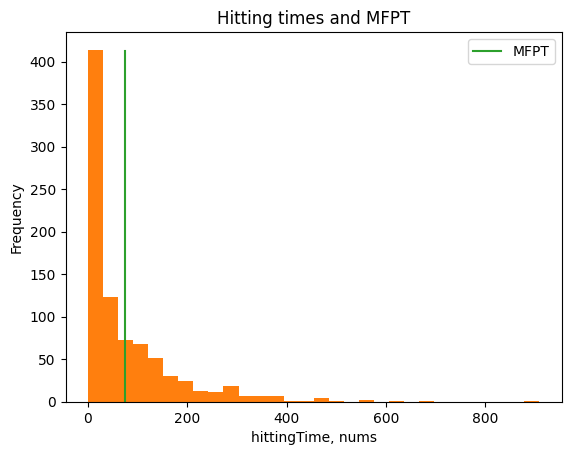

In [89]:
#Histogram hitting times and plot MFPT
hit = hittingTime[hittingTime != 0]
#Should zero be removed for MFPT calculation?
MFPT = np.average(hit)
print("Mean First Passage Time = ", MFPT)
plt.plot(np.tile(MFPT, int(max(plt.hist(hit, 30)[0]))), range(int(max(plt.hist(hit, 30)[0]))), label="MFPT")
#plt.hist(hit, 30, label="Zero removed")
#plt.hist(hittingTime, 30, label="Zero inflated")
plt.ylabel("Frequency")
plt.xlabel("hittingTime, nums")
plt.title("Hitting times and MFPT")
plt.legend()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Hist_Strat_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

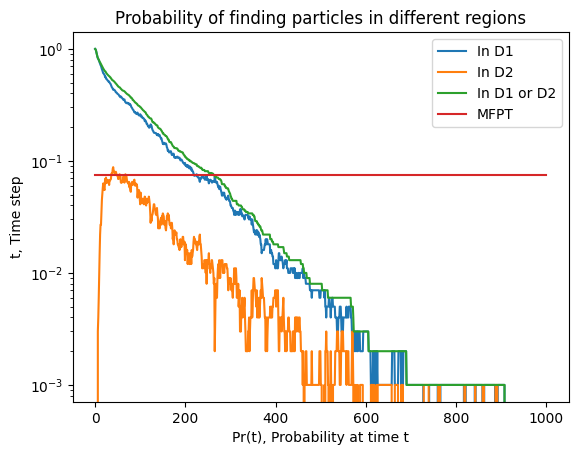

In [90]:
#Probability of finding a particle in medium1 or medium2 or hiting the target
count1 = np.zeros(nums)
count2 = np.zeros(nums)
count3 = np.zeros(nums)
for t in range(nums):
  for p in range(nump):
    count3[t] += np.count_nonzero((0 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R))
    count1[t] += np.count_nonzero((R < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R1))
    count2[t] += np.count_nonzero((R1 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R2))

xticks = np.linspace(1/nums, 1, nums)
yticks = np.linspace(1/nums, 1, nums)
plt.yscale("log")
plt.plot(count1/nump)
plt.plot(count2/nump)
plt.plot((count1 + count2)/nump)
plt.plot(np.tile(MFPT/nums, nums))
#plt.plot(count3/nump)
plt.legend(["In D1", "In D2", "In D1 or D2", "MFPT", "Hit target"])
plt.ylabel("t, Time step")
plt.xlabel("Pr(t), Probability at time t")
plt.title("Probability of finding particles in different regions")
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Prob_Strat_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

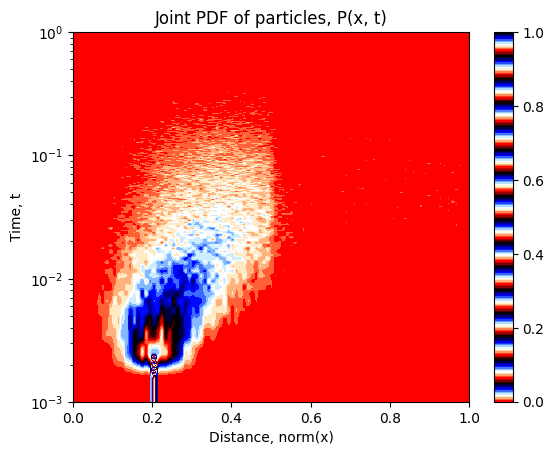

In [91]:
#Plot a heatmap of probability of particles
gridX = 100
gridT = nums
pos = np.round(np.linspace(0, 1, gridX + 1), 2)
tim = np.linspace(0, gridT, gridT+1)
PDF1D = np.zeros((gridT, gridX+1))

#Derive a heatmap of the particles
#Find the norm of particles at each time step
Z = np.linalg.norm(Y/R2, axis=0)

#Quantize it to 2 ( = log10(gridX)) decimal places as grix X is with such precision
Z = np.round(Z, 2)

for t in range(nums):
#position of all particles at time t
  for p in range(len(pos)):
    PDF1D[t][p] = np.count_nonzero(Z[t, :] == pos[p])

#Plot the heatmap of pdf
plt.title("Joint PDF of particles, P(x, t)")
#PDF1D is a 2D matrix with (0,0)th element on top left. Fip vertically
plt.yscale('log')
plt.imshow(np.flipud(PDF1D/nump), cmap = 'flag', extent = [0, 1, dt, dt*nums], aspect = "auto")
plt.xlabel("Distance, norm(x)")
plt.ylabel("Time, t")
plt.colorbar()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Heat_Strat_{nump}_{nums}_{D1}_{D2}.png')
#https://stackoverflow.com/questions/2546475/how-can-i-draw-a-log-normalized-imshow-plot-with-a-colorbar-representing-the-raw

# Simulate Isothermal Convention

In [92]:
#Hitting times if the target is hit
hittingTime = np.zeros(nump)
#Trajectory of a particle
X = np.zeros([dim, nums])
#Trajectories of all particles
Y = np.zeros([dim, nums, nump])


start_time = time.time()
for i in range(nump):
  #Initialize - The particle starts at a random positio outside the target
  if dim == 1:
    X[:, 0] = Init1D[i]
  elif dim == 2:
    X[:, 0] = Init2D[:, i]
  elif dim == 3:
    X[:, 0] = Init3D[:, i]

  #Find particle trajectories
  for j in range(1, nums):
    #Random increment in the position
    dRand = Eps[i, j, :]
    #Increment if particle is in medium1
    dX1 = dX1s[i, j, :]
    #Increment if particle is in medium2
    dX2 = dX2s[i, j, :]

    #Particle hits the target
    if R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) < R:
      X[:, j] = X[:, j - 1] + dX1
      X[:, j+1:] = -1
      hittingTime[i] = j
      break

    #Particle travels in medium1, without hitting the target
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and R < np.linalg.norm(X[:, j - 1] + dX1) < R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle is traveling in medium2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and R1 < np.linalg.norm(X[:, j - 1] + dX2) < R2:
      X[:, j] = X[:, j - 1] + dX2

    #Particle is reflected by the outer ball when its next step crosses the bound R2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) > R2:
      #Find the point of reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) + np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R2**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Image in D2
      X[:, j] = X[:, j - 1] + dX2 - 2*(1 - lamb)*np.dot(dX2, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

    #Particle diffuses from D1 to D2 with a one sided reflection coefficient
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) > R1:
      #Find the point of diffusion/reflection
      lamb = ( -np.dot(X[:, j - 1], dX1) + np.sqrt(np.dot(X[:, j - 1], dX1)**2 - (np.linalg.norm(dX1)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX1)**2)
      r0 = X[:, j - 1] + lamb*dX1
      if any(np.linalg.norm(r0 - poreCenters, axis=1) < r):
        #If particle's projection on surface of the inner ball is near any pore, diffuse to D2.
        if bernoulli.rvs(min(1, math.sqrt(D2/D1))):
          #Diffuse with time-splitting, if the random variable generated is 1
          #Residence times in each medium
          dt1 = (np.linalg.norm(lamb*dX1)/(np.linalg.norm(dRand)*np.sqrt(2*D1)))**2
          dt2 = ((1 - np.sqrt(dt1/dt))**2)*dt
          #Particle diffuses, increment by motion in D2
          X[:, j] = r0 + np.sqrt(2*D2*dt2)*dRand
        else:
          #Reflect, if the random variable generated is 0
          X[:, j] = X[:, j - 1] + dX1 - 2*(1-lamb)*np.dot(dX1, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)
      else:
          #Reflect particle is far from all pores
          X[:, j] = X[:, j - 1] + dX1 - 2*(1-lamb)*np.dot(dX1, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)

    #Particle diffuses from D2 to D1 with a one sided reflection coefficient
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) < R1:
      #Find the point of diffusion/reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) - np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      if any(np.linalg.norm(r0 - poreCenters, axis=1) < r):
        #If particle's projection on surface of the inner ball is near any pore, diffuse to D2.
        if bernoulli.rvs(min(1, math.sqrt(D1/D2))):
          #Diffuse with time-splitting, if the random variable generated is 1
          #Residence times in each medium
          dt2 = (np.linalg.norm(lamb*dX2)/(np.linalg.norm(dRand)*np.sqrt(2*D2)))**2
          dt1 = ((1 - np.sqrt(dt2/dt))**2)*dt
          #Particle diffuses, increment by motion in D1
          X[:, j] = r0 + np.sqrt(2*D1*dt1)*dRand
        else:
          #Reflect, if the random variable generated is 0
          X[:, j] = X[:, j - 1] + dX2 - 2*(1-lamb)*np.dot(dX2, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)
      else:
          #Reflect, if projection is far from all pores
          X[:, j] = X[:, j - 1] + dX2 - 2*(1-lamb)*np.dot(dX2, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)

  #Save the particle's trajectory
  Y[:, :, i] = X
  #print(i)

#Time taken to simulate motion of nump particles each taking nums steps
print("nump = ", nump, "nums = ", nums, "--- %s seconds ---" % (time.time() - start_time))

nump =  1000 nums =  1000 --- 11.20415186882019 seconds ---


# Plots

Mean First Passage Time =  73.18985849056604


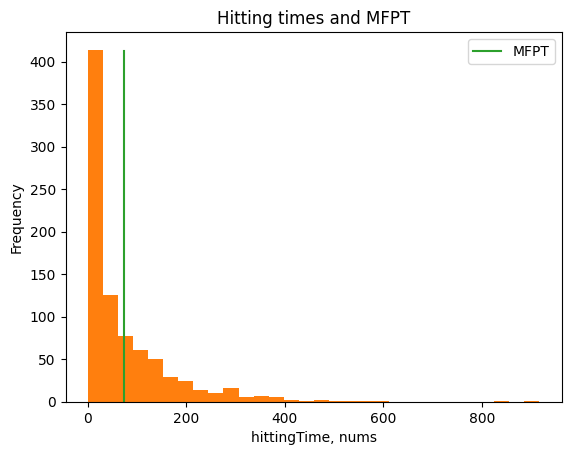

In [93]:
#Histogram hitting times and plot MFPT
hit = hittingTime[hittingTime != 0]
#Should zero be removed for MFPT calculation?
MFPT = np.average(hit)
print("Mean First Passage Time = ", MFPT)
plt.plot(np.tile(MFPT, int(max(plt.hist(hit, 30)[0]))), range(int(max(plt.hist(hit, 30)[0]))), label="MFPT")
#plt.hist(hit, 30, label="Zero removed")
#plt.hist(hittingTime, 30, label="Zero inflated")
plt.ylabel("Frequency")
plt.xlabel("hittingTime, nums")
plt.title("Hitting times and MFPT")
plt.legend()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Hist_Iso_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

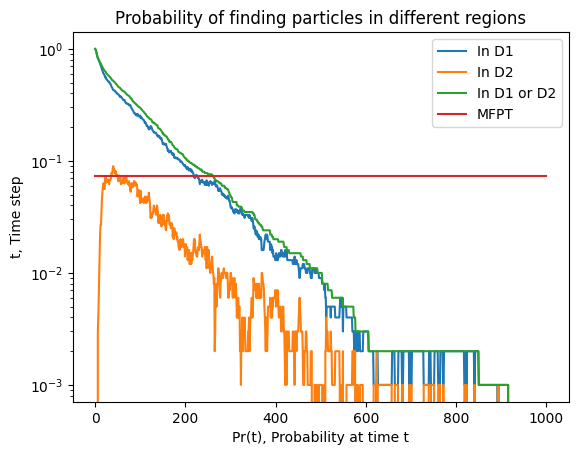

In [94]:
#Probability of finding a particle in medium1 or medium2 or hiting the target
count1 = np.zeros(nums)
count2 = np.zeros(nums)
count3 = np.zeros(nums)
for t in range(nums):
  for p in range(nump):
    count3[t] += np.count_nonzero((0 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R))
    count1[t] += np.count_nonzero((R < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R1))
    count2[t] += np.count_nonzero((R1 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R2))

xticks = np.linspace(1/nums, 1, nums)
yticks = np.linspace(1/nums, 1, nums)
plt.yscale("log")
plt.plot(count1/nump)
plt.plot(count2/nump)
plt.plot((count1 + count2)/nump)
plt.plot(np.tile(MFPT/nums, nums))
#plt.plot(count3/nump)
plt.legend(["In D1", "In D2", "In D1 or D2", "MFPT", "Hit target"])
plt.ylabel("t, Time step")
plt.xlabel("Pr(t), Probability at time t")
plt.title("Probability of finding particles in different regions")
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Prob_Iso_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

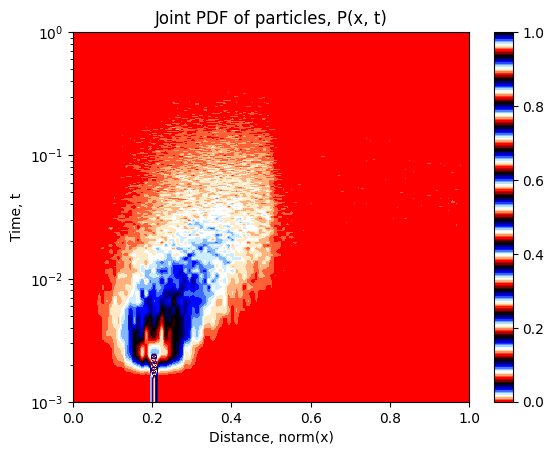

In [95]:
#Plot a heatmap of probability of particles
gridX = 100
gridT = nums
pos = np.round(np.linspace(0, 1, gridX + 1), 2)
tim = np.linspace(0, gridT, gridT+1)
PDF1D = np.zeros((gridT, gridX+1))

#Derive a heatmap of the particles
#Find the norm of particles at each time step
Z = np.linalg.norm(Y/R2, axis=0)

#Quantize it to 2 ( = log10(gridX)) decimal places as grix X is with such precision
Z = np.round(Z, 2)

for t in range(nums):
#position of all particles at time t
  for p in range(len(pos)):
    PDF1D[t][p] = np.count_nonzero(Z[t, :] == pos[p])

#Plot the heatmap of pdf
plt.title("Joint PDF of particles, P(x, t)")
#PDF1D is a 2D matrix with (0,0)th element on top left. Fip vertically
plt.yscale('log')
plt.imshow(np.flipud(PDF1D/nump), cmap = 'flag', extent = [0, 1, dt, dt*nums], aspect = "auto")
plt.xlabel("Distance, norm(x)")
plt.ylabel("Time, t")
plt.colorbar()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Heat_Ito_{nump}_{nums}_{D1}_{D2}.png')